#### Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

#### Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

#### Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

#### Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!




# Load the Data/Filtering for Chosen Zipcodes

In [2]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')
from statsmodels.tsa.stattools import adfuller


In [3]:
#Import file and observe data structure
df = pd.read_csv('zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
#Create a df with zipcodes that only apply to the Fort Worth/Tarrant County
fw_df = df[df['CountyName']=='Tarrant']
fw_df.tail(2)

RegionID  RegionName       City State              Metro CountyName  \
9339      91219       76060  Kennedale    TX  Dallas-Fort Worth    Tarrant   
13312     91179       76005  Arlington    TX  Dallas-Fort Worth    Tarrant   

       SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
9339       9340  139300.0  139100.0  138800.0  ...   231600   234300   235400   
13312     13313  200100.0  200000.0  199800.0  ...   388700   386400   383300   

       2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
9339    236700   237400   237500   237900   240000   242200   243200  
13312   379400   375100   374200   374200   373700   373900   373900  

[2 rows x 272 columns]

In [5]:
#Observe dimensions of the new df
fw_df.shape

(59, 272)

In [6]:
#View df info
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 153 to 13312
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 125.8+ KB


* As the scope of this project is concerned with housing prices over time for specific zipcodes, at this time all unnecessary columns can be dropped from the df.

In [7]:
#Drop columns
fw_df = fw_df.drop(["RegionID", "City", "State", "Metro", "CountyName", "SizeRank"], axis=1)

In [8]:
# Rename RegionName column more appropriately to Zipcode
fw_df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
fw_df.head()

Zipcode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
153    76063  148100.0  148000.0  147800.0  147700.0  147500.0  147400.0   
170    76244  139800.0  140100.0  140700.0  141500.0  142300.0  143100.0   
335    76116   85800.0   86100.0   86500.0   87000.0   87500.0   88000.0   
550    76179  107100.0  107600.0  108100.0  108800.0  109500.0  110400.0   
562    76137  117500.0  117500.0  117600.0  117800.0  117900.0  118100.0   

      1996-10   1996-11   1996-12  ...  2017-07  2017-08  2017-09  2017-10  \
153  147300.0  147200.0  147200.0  ...   257200   258700   259000   259600   
170  143800.0  144600.0  145200.0  ...   245600   246700   246700   247500   
335   88400.0   88800.0   89000.0  ...   172400   174500   176000   178000   
550  111300.0  112400.0  113300.0  ...   191500   193200   194300   195500   
562  118400.0  118600.0  118900.0  ...   190700   191400   191800   192800   

     2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
153   260200   261100   262200   264100   266500   267800  
170   248500   249700   250300   251000   251400   251300  
335   180000   181900   183300   185000   186600   187800  
550   196700   198100   199000   200000   201200   202100  
562   193800   195400   197000   198700   200500   201700  

[5 rows x 266 columns]

# Reshape from Wide to Long Format

In [9]:
#Reset the index from the old df
fw_df.reset_index(drop=True)

Zipcode   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09  \
0     76063  148100.0  148000.0  147800.0  147700.0  147500.0  147400.0   
1     76244  139800.0  140100.0  140700.0  141500.0  142300.0  143100.0   
2     76116   85800.0   86100.0   86500.0   87000.0   87500.0   88000.0   
3     76179  107100.0  107600.0  108100.0  108800.0  109500.0  110400.0   
4     76137  117500.0  117500.0  117600.0  117800.0  117900.0  118100.0   
5     76051  188200.0  189100.0  190000.0  190900.0  191800.0  192600.0   
6     76133   77500.0   77700.0   77800.0   78000.0   78200.0   78400.0   
7     76010   56100.0   56200.0   56300.0   56500.0   56600.0   56700.0   
8     76112   65500.0   65500.0   65600.0   65800.0   66000.0   66100.0   
9     76017  105400.0  105400.0  105500.0  105600.0  105800.0  106000.0   
10    76039  119500.0  119600.0  119600.0  119700.0  119800.0  120000.0   
11    76108   81600.0   81500.0   81400.0   81400.0   81400.0   81500.0   
12    76021  132000.0  131600.0  131300.0  131000.0  130800.0  130600.0   
13    76107  122600.0  124100.0  125700.0  127200.0  128700.0  129900.0   
14    76119   40500.0   40600.0   40700.0   40800.0   41000.0   41300.0   
15    76180   98700.0   98700.0   98700.0   98700.0   98600.0   98600.0   
16    76248  210400.0  210500.0  210600.0  210600.0  210500.0  210400.0   
17    76006  162100.0  162300.0  162400.0  162600.0  162800.0  163000.0   
18    76013  100100.0  100400.0  100600.0  100900.0  101200.0  101400.0   
19    76132  214800.0  217500.0  220000.0  221900.0  223300.0  224200.0   
20    76131  117400.0  117300.0  117300.0  117300.0  117600.0  117900.0   
21    76053   88700.0   89000.0   89200.0   89600.0   89900.0   90100.0   
22    76182  129400.0  129500.0  129600.0  129700.0  129800.0  129900.0   
23    76117   56700.0   56800.0   56800.0   57000.0   57100.0   57200.0   
24    76040  118900.0  118500.0  118000.0  117600.0  117200.0  117000.0   
25    76016  118900.0  119100.0  119200.0  119400.0  119500.0  119700.0   
26    76014   69300.0   69300.0   69500.0   69700.0   69800.0   70000.0   
27    76020   87500.0   87500.0   87500.0   87600.0   87700.0   87800.0   
28    76012  120800.0  120800.0  120900.0  121000.0  121100.0  121100.0   
29    76001  125900.0  125800.0  125800.0  125900.0  126000.0  126100.0   
30    76109  262000.0  260900.0  259400.0  257400.0  255000.0  252100.0   
31    76011   72600.0   72700.0   72800.0   72900.0   73100.0   73200.0   
32    76123  126100.0  126500.0  126800.0  127200.0  127400.0  127500.0   
33    76140   78500.0   78100.0   77800.0   77500.0   77200.0   77000.0   
34    76092  422800.0  424200.0  425400.0  426200.0  426800.0  427000.0   
35    76036  113000.0  113400.0  113700.0  113800.0  113800.0  113700.0   
36    76002  129300.0  128900.0  128500.0  128100.0  127700.0  127400.0   
37    76114   56000.0   56000.0   56000.0   56100.0   56200.0   56300.0   
38    76126  105900.0  105800.0  105700.0  105700.0  105600.0  105600.0   
39    76034  297900.0  297600.0  297500.0  297800.0  298300.0  299000.0   
40    76134   72000.0   72400.0   72700.0   73100.0   73500.0   73800.0   
41    76018   91300.0   91500.0   91700.0   92000.0   92300.0   92600.0   
42    76148   74600.0   74600.0   74500.0   74600.0   74600.0   74700.0   
43    76135   84900.0   85000.0   85100.0   85300.0   85600.0   85900.0   
44    76120  101600.0  101900.0  102200.0  102500.0  102800.0  103000.0   
45    76105   33100.0   33600.0   34100.0   34600.0   35000.0   35500.0   
46    76015   84700.0   84700.0   84800.0   84900.0   84900.0   85000.0   
47    76052  140500.0  140700.0  141000.0  141600.0  142500.0  143500.0   
48    76111   52300.0   52300.0   52300.0   52300.0   52300.0   52300.0   
49    76177  140000.0  140200.0  140500.0  140800.0  141100.0  141500.0   
50    76104   35500.0   35600.0   35700.0   35800.0   35800.0   35900.0   
51    76022   92400.0   92600.0   92900.0   93000.0   93300.0   93500.0   
52    76118   94500.0   94600

In [10]:
#Convert Zipcodes from integers to strings
fw_df["Zipcode"]=fw_df['Zipcode'].astype(str)

In [11]:
#Transpose the df to convert time into rows and zipcodes into columns
fw_df=fw_df.transpose()
fw_df.head(2)

153     170    335     550     562     602    816    902    1159   \
Zipcode   76063   76244  76116   76179   76137   76051  76133  76010  76112   
1996-04  148100  139800  85800  107100  117500  188200  77500  56100  65500   

          1185   ...   6540   6646   6769   6984    7426   7548    7748   \
Zipcode   76017  ...   76177  76104  76022  76118   76247  76103   76054   
1996-04  105400  ...  140000  35500  92400  94500  128600  55000  131400   

         7980    9339    13312  
Zipcode  76164   76060   76005  
1996-04  40300  139300  200100  

[2 rows x 59 columns]

In [12]:
#Rename columns to approriately reflect zipcode home values

col_names = fw_df.iloc[0] #Take the first row (zipcodes) for column names
fw_df=fw_df[1:] #make new df with all rows following the first row
fw_df.columns=col_names #Assign zipcodes as column headers

In [13]:
fw_df.head()

Zipcode   76063   76244  76116   76179   76137   76051  76133  76010  76112  \
1996-04  148100  139800  85800  107100  117500  188200  77500  56100  65500   
1996-05  148000  140100  86100  107600  117500  189100  77700  56200  65500   
1996-06  147800  140700  86500  108100  117600  190000  77800  56300  65600   
1996-07  147700  141500  87000  108800  117800  190900  78000  56500  65800   
1996-08  147500  142300  87500  109500  117900  191800  78200  56600  66000   

Zipcode   76017  ...   76177  76104  76022  76118   76247  76103   76054  \
1996-04  105400  ...  140000  35500  92400  94500  128600  55000  131400   
1996-05  105400  ...  140200  35600  92600  94600  128800  55100  131600   
1996-06  105500  ...  140500  35700  92900  94700  129100  55300  131800   
1996-07  105600  ...  140800  35800  93000  94900  129400  55400  132000   
1996-08  105800  ...  141100  35800  93300  95000  129800  55600  132200   

Zipcode  76164   76060   76005  
1996-04  40300  139300  200100  
1996-05  40400  139100  200000  
1996-06  40400  138800  199800  
1996-07  40500  138600  199700  
1996-08  40500  138400  199500  

[5 rows x 59 columns]

In [14]:
fw_df.shape

(265, 59)

* The new dataframe now has dimensions of 59 columns (#of provided Tarrant county zipcodes) and 265 row (#months between recorded first median home value and last home value)

# Data Preprocessing

In [15]:
#def get_datetimes(df):
#    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [16]:
#change df index to datetime format
fw_df.index=pd.to_datetime(fw_df.index)
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   76063   265 non-null    object
 1   76244   265 non-null    object
 2   76116   265 non-null    object
 3   76179   265 non-null    object
 4   76137   265 non-null    object
 5   76051   265 non-null    object
 6   76133   265 non-null    object
 7   76010   265 non-null    object
 8   76112   265 non-null    object
 9   76017   265 non-null    object
 10  76039   265 non-null    object
 11  76108   265 non-null    object
 12  76021   265 non-null    object
 13  76107   265 non-null    object
 14  76119   265 non-null    object
 15  76180   265 non-null    object
 16  76248   265 non-null    object
 17  76006   265 non-null    object
 18  76013   265 non-null    object
 19  76132   265 non-null    object
 20  76131   265 non-null    object
 21  76053   265 non-null    object
 22  76182  

In [17]:
#convert home prices from object to integer
fw_df=fw_df.astype(int)

In [18]:
fw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76063   265 non-null    int32
 1   76244   265 non-null    int32
 2   76116   265 non-null    int32
 3   76179   265 non-null    int32
 4   76137   265 non-null    int32
 5   76051   265 non-null    int32
 6   76133   265 non-null    int32
 7   76010   265 non-null    int32
 8   76112   265 non-null    int32
 9   76017   265 non-null    int32
 10  76039   265 non-null    int32
 11  76108   265 non-null    int32
 12  76021   265 non-null    int32
 13  76107   265 non-null    int32
 14  76119   265 non-null    int32
 15  76180   265 non-null    int32
 16  76248   265 non-null    int32
 17  76006   265 non-null    int32
 18  76013   265 non-null    int32
 19  76132   265 non-null    int32
 20  76131   265 non-null    int32
 21  76053   265 non-null    int32
 22  76182   265 non-null    int32
 

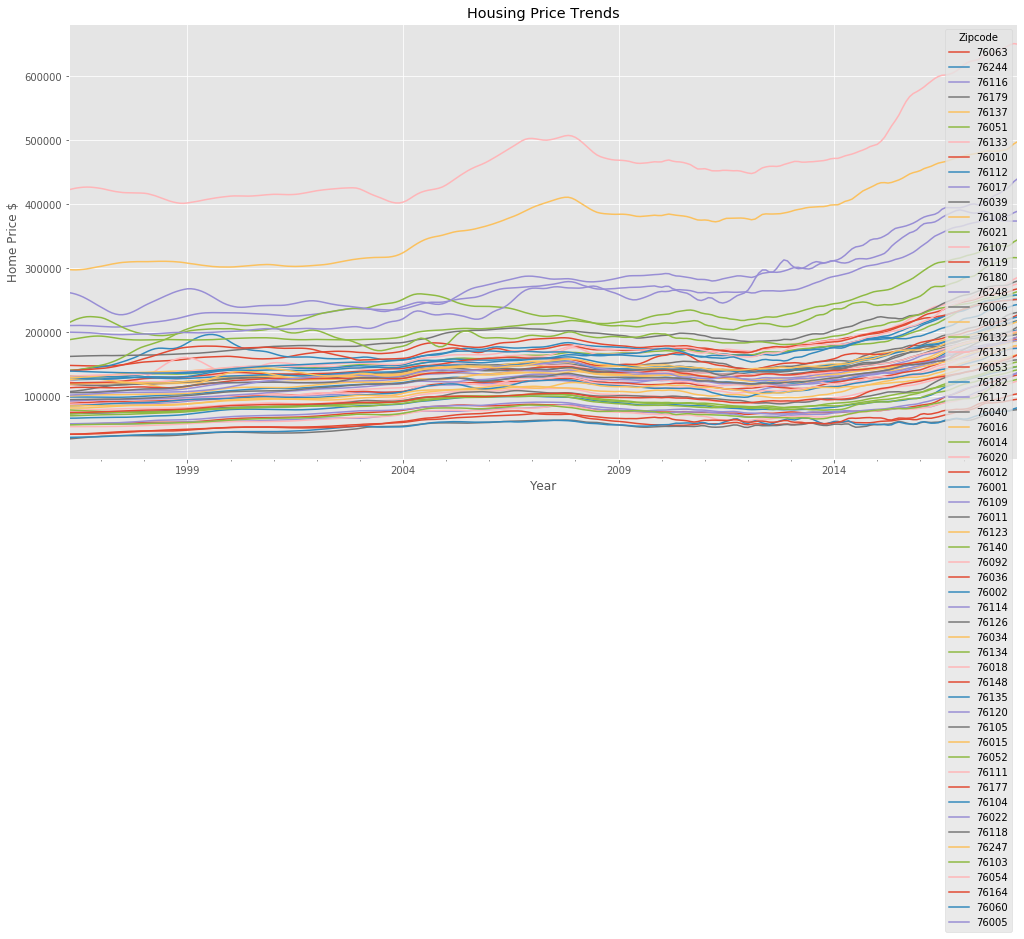

In [22]:
#Visualize all Tarrant County median home prices for each zipcode over time.
fw_df.plot(figsize=(17,8), legend='best')
plt.title("Housing Price Trends")
plt.xlabel('Year')
plt.ylabel('Home Price $');

In [20]:
#annual_price = fw_df.resample('A').mean()

In [21]:
#annual_price.info()

In [27]:
fw_df.head()

Zipcode      76063   76244  76116   76179   76137   76051  76133  76010  \
1996-04-01  148100  139800  85800  107100  117500  188200  77500  56100   
1996-05-01  148000  140100  86100  107600  117500  189100  77700  56200   
1996-06-01  147800  140700  86500  108100  117600  190000  77800  56300   
1996-07-01  147700  141500  87000  108800  117800  190900  78000  56500   
1996-08-01  147500  142300  87500  109500  117900  191800  78200  56600   

Zipcode     76112   76017  ...   76177  76104  76022  76118   76247  76103  \
1996-04-01  65500  105400  ...  140000  35500  92400  94500  128600  55000   
1996-05-01  65500  105400  ...  140200  35600  92600  94600  128800  55100   
1996-06-01  65600  105500  ...  140500  35700  92900  94700  129100  55300   
1996-07-01  65800  105600  ...  140800  35800  93000  94900  129400  55400   
1996-08-01  66000  105800  ...  141100  35800  93300  95000  129800  55600   

Zipcode      76054  76164   76060   76005  
1996-04-01  131400  40300  139300  200100  
1996-05-01  131600  40400  139100  200000  
1996-06-01  131800  40400  138800  199800  
1996-07-01  132000  40500  138600  199700  
1996-08-01  132200  40500  138400  199500  

[5 rows x 59 columns]

* As the investors are looking for high risk high, high reward investments, it's prudent to take into account the historical performance of each zipcode. To do so calculating return on investment (ROI) is the best indicator (with the provided data) of how an initial investment in 1996 has performed through to 2018. ROI is calculated by subracting the current value of the home by the initial investment, divided by the initial investment. This will yield each zipcodes profitability over time.

In [28]:
# Create an empty list to store roi for each zipcode
zds = []

# Loop through each zipcode (column) and calculate roi
for zipcode in fw_df.columns.tolist():
    roi = (fw_df[zipcode][-1]-fw_df[zipcode][0])/fw_df[zipcode][0]
    zd ={'zipcode': zipcode, 'roi': roi}
    zds.append(zd)
    
#Convert roi list to df    
roi_df = pd.DataFrame(zds)
roi_df

zipcode       roi
0    76063  0.808238
1    76244  0.797568
2    76116  1.188811
3    76179  0.887021
4    76137  0.716596
5    76051  0.829968
6    76133  1.127742
7    76010  1.372549
8    76112  1.235115
9    76017  0.891841
10   76039  0.933054
11   76108  1.013480
12   76021  0.958333
13   76107  1.328711
14   76119  1.348148
15   76180  1.059777
16   76248  0.849810
17   76006  0.727946
18   76013  0.993007
19   76132  0.473464
20   76131  0.719761
21   76053  1.127396
22   76182  0.994590
23   76117  1.391534
24   76040  0.832632
25   76016  0.822540
26   76014  1.215007
27   76020  1.028571
28   76012  0.877483
29   76001  0.725179
30   76109  0.679008
31   76011  1.159780
32   76123  0.480571
33   76140  0.797452
34   76092  0.538789
35   76036  0.701770
36   76002  0.730858
37   76114  1.446429
38   76126  0.965061
39   76034  0.671366
40   76134  1.033333
41   76018  0.924425
42   76148  1.203753
43   76135  1.058893
44   76120  0.844488
45   76105  1.380665
46   76015  1.115702
47   76052  0.874733
48   76111  1.365201
49   76177  0.795000
50   76104  1.304225
51   76022  1.080087
52   76118  1.080423
53   76247  0.684292
54   76103  1.296364
55   76054  1.096651
56   76164  1.570720
57   76060  0.745872
58   76005  0.868566

In [29]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [30]:
df.loc[df['RegionName'] == 76164]

RegionID  RegionName        City State              Metro CountyName  \
7980     91289       76164  Fort Worth    TX  Dallas-Fort Worth    Tarrant   

      SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
7980      7981  40300.0  40400.0  40400.0  ...    91100    92500    93700   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
7980    94700    96000    97600    99500   101000   102600   103600  

[1 rows x 272 columns]

In [31]:
df.loc[df['RegionName'] == 76114]


RegionID  RegionName        City State              Metro CountyName  \
4576     91259       76114  Fort Worth    TX  Dallas-Fort Worth    Tarrant   

      SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
4576      4577  56000.0  56000.0  56000.0  ...   111000   114000   116400   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
4576   119000   122200   125700   127700   130200   134000   137000  

[1 rows x 272 columns]

In [32]:
df.loc[df['RegionName'] == 76117]

RegionID  RegionName         City State              Metro CountyName  \
3340     91262       76117  Haltom City    TX  Dallas-Fort Worth    Tarrant   

      SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
3340      3341  56700.0  56800.0  56800.0  ...   122100   125000   126900   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
3340   128400   129800   130900   131600   132700   134300   135600  

[1 rows x 272 columns]

In [33]:
df.loc[df['RegionName'] == 76105]

RegionID  RegionName        City State              Metro CountyName  \
6033     91250       76105  Fort Worth    TX  Dallas-Fort Worth    Tarrant   

      SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
6033      6034  33100.0  33600.0  34100.0  ...    70700    72900    75000   

      2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
6033    76400    76400    76400    76800    77400    78300    78800  

[1 rows x 272 columns]

In [34]:
df.loc[df['RegionName'] == 76010]

RegionID  RegionName       City State              Metro CountyName  \
902     91184       76010  Arlington    TX  Dallas-Fort Worth    Tarrant   

     SizeRank  1996-04  1996-05  1996-06  ...  2017-07  2017-08  2017-09  \
902       903  56100.0  56200.0  56300.0  ...   118900   120800   122300   

     2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
902   123700   125200   127000   128700   130300   131900   133100  

[1 rows x 272 columns]

In [35]:
top_10_df = fw_df[['76164', '76114', '76117', '76105', '76010', '76111', '76119',
              '76107', '76104', '76103']]

In [36]:
top_10_df.head()

Zipcode     76164  76114  76117  76105  76010  76111  76119   76107  76104  \
1996-04-01  40300  56000  56700  33100  56100  52300  40500  122600  35500   
1996-05-01  40400  56000  56800  33600  56200  52300  40600  124100  35600   
1996-06-01  40400  56000  56800  34100  56300  52300  40700  125700  35700   
1996-07-01  40500  56100  57000  34600  56500  52300  40800  127200  35800   
1996-08-01  40500  56200  57100  35000  56600  52300  41000  128700  35800   

Zipcode     76103  
1996-04-01  55000  
1996-05-01  55100  
1996-06-01  55300  
1996-07-01  55400  
1996-08-01  55600

# EDA and Visualization

In [37]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 22}

#matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Initial Visualizations 

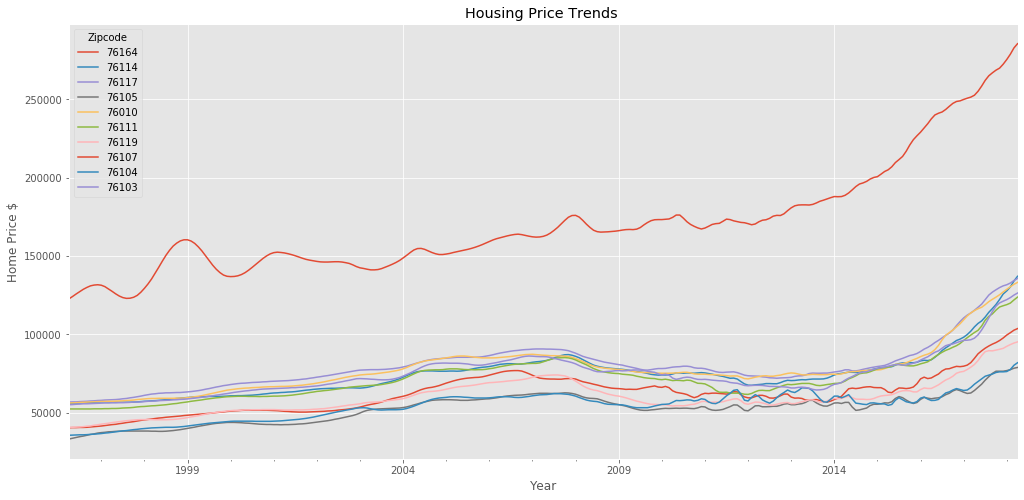

In [38]:
#Visialize top 10 performing zipcodes in the FW area
top_10_df.plot(figsize=(17,8))
plt.title("Housing Price Trends ")
plt.xlabel('Year')
plt.ylabel('Home Price $');

* There is a clear positive trend, as expected, for the top performing zipcodes. This must be addressed prior to modeling through detrending.


* Although there is am obvious dip in home values following the 2008-2009 financial crisis along with some minimal variance, there isn't an apparent seasonal price fluctuations in the above graph. Perhaps this is due to the scale of the graph. However, seasonality must also be addressed prior to modeling if it is found to exist later in this analysis.

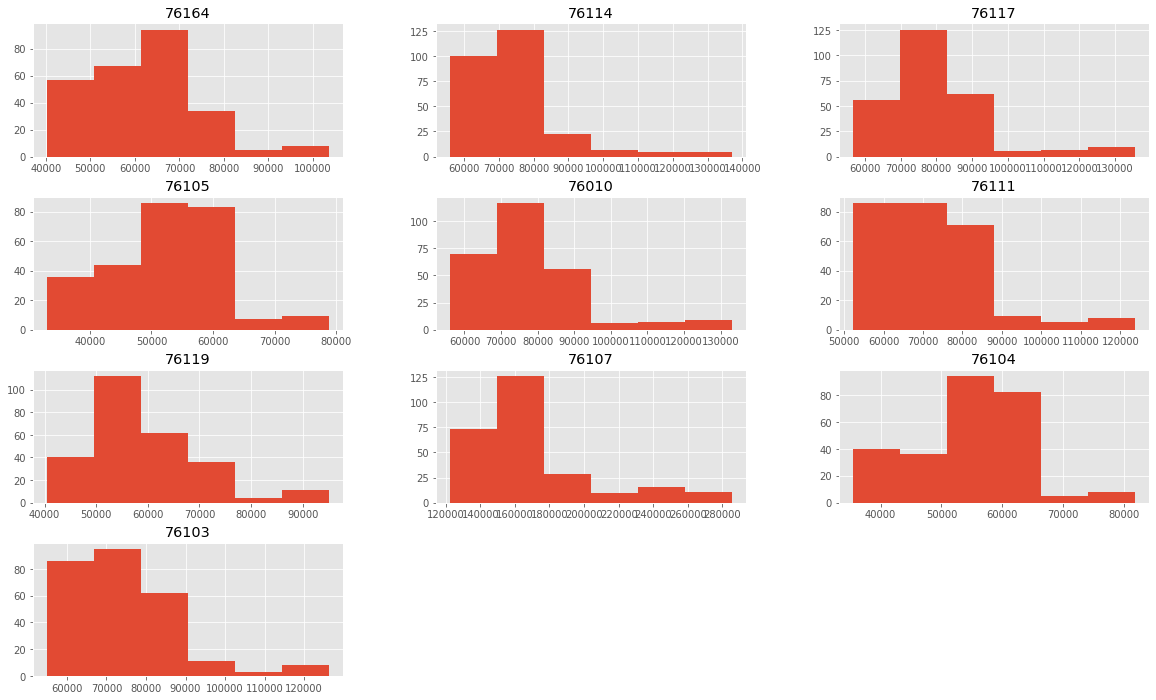

In [39]:
#Visualize price histogram for each zipcode
top_10_df.hist(figsize= (20, 12), bins=6);

* The histogram plot for each zipcode don't look particularly Gaussian. For time series forecasting a normal distribution of the data will help with more accurate predictions. This must addressed prior to modeling.

In [40]:
#top_10_df_diff = top_10_df.diff(periods=1)

In [41]:
#top_10_df_diff.plot(figsize=(18,6))

## Stationarity Check

* As seen from the previous graphs, there is clearly a trend to the data over time and perhaps some unseen seasonality that need to be addressed prior to modeling. In order to make sure that the data are ready to be modeled, there are some clear method to apply to the housing data in order to confirm that stationarity is met prior to moving forward with modeling and forecasting.

### Rolling Mean

* Rolling statistics such as average and standard deviation shows how values vary with time. The goal is to have a rolling mean that stays constant. We can graph rolling statistics to visualize whether or not the data meet this criteria.

In [42]:
# create a function that takes in a df and a window of time and outputs a graph 
# of the rolling statistics.
def rolling_stats(TS, window):
     
    roll_mean = TS.rolling(window=window, center=False).mean()
    roll_std = TS.rolling(window=window, center=False).std()
    
    
    fig=plt.figure(figsize=(12, 6))
    plt.plot(TS, color='blue', label = 'Original')
    plt.plot(roll_mean, color='red', label = 'Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & STD')
    plt.show(block=False)


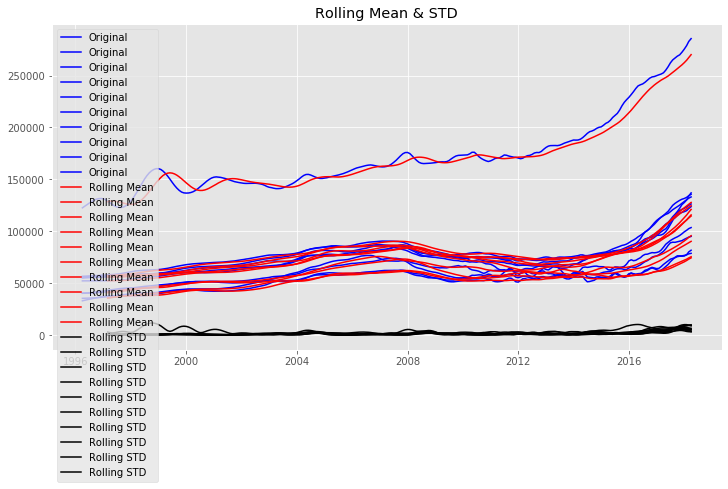

In [43]:
rolling_stats(top_10_df, 12)

* The rolling mean with a 12 month window is not constant. Therefore, it's reconfirmed from previous graphs that the time series is not stationary

### Dickey Fuller Test

* It's already been confirmed that there is a positive trend in home values over time. Meaning there's at least some normalizing that needs to occur prior to modeling. A way to check and see if data are ready for the next step is the Dickey Fuller Test. This test specifically tests for stationarity. The null hypothesis for this test is that the time series is not stationary. So, the test statistics must be less than the critical p-value to confirm the data are stationary and modeling can commence. 

In [44]:
#Create a dickey fuller funtion to iterate through each zipcode (column) and print
# test statistics.
def dickey_fuller_test(df):  
    for col in df.columns: 
        dftest = adfuller(df[col]) 
        
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value',
                                            '#Lags Used', '#Observations Used'])
    
        for key, value in dftest[4].items():
            dfoutput['Critical Value (%s)' %key] = value
        
        print(f'Dickey-Fuller Results: {col} \n')
        print(dfoutput)
        print('\n')


In [45]:
dickey_fuller_test(top_10_df)

Dickey-Fuller Results: 76164 

Test Statistics           0.019309
p-value                   0.960100
#Lags Used               16.000000
#Observations Used      248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics           1.316249
p-value                   0.996698
#Lags Used                6.000000
#Observations Used      258.000000
Critical Value (1%)      -3.455953
Critical Value (5%)      -2.872809
Critical Value (10%)     -2.572775
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics          -0.881781
p-value                   0.793913
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics          -0.059105
p-value                   0.953363
#Lags Used          

* The Dickey Fuller test results confirm what is already known; the time series for each zipcode are not stationary. In fact, the p-values are incredibly high ranging between 0.74 and 0.99. 

## Detrending

### Log Transformations

* One way to normalize data in an attempt to make it stationary is a log transformation, where higher values are penalized more than lower values.

In [46]:
#Create a function that log transforms each value in the dataframe
log_list = []
def log_transform(df):

    for col in df.columns:
        logs = pd.Series(np.log(df[col]))
        log_list.append(logs)
    return log_list

test = log_transform(top_10_df)
log_df = pd.DataFrame(test).transpose()
log_df.head()


76164      76114      76117      76105      76010      76111  \
1996-04-01  10.604107  10.933107  10.945529  10.407289  10.934891  10.864752   
1996-05-01  10.606585  10.933107  10.947292  10.422281  10.936672  10.864752   
1996-06-01  10.606585  10.933107  10.947292  10.437053  10.938450  10.864752   
1996-07-01  10.609057  10.934891  10.950807  10.451609  10.941996  10.864752   
1996-08-01  10.609057  10.936672  10.952559  10.463103  10.943764  10.864752   

                76119      76107      76104      76103  
1996-04-01  10.609057  11.716682  10.477288  10.915088  
1996-05-01  10.611523  11.728843  10.480101  10.916905  
1996-06-01  10.613983  11.741653  10.482906  10.920528  
1996-07-01  10.616437  11.753516  10.485703  10.922335  
1996-08-01  10.621327  11.765239  10.485703  10.925938

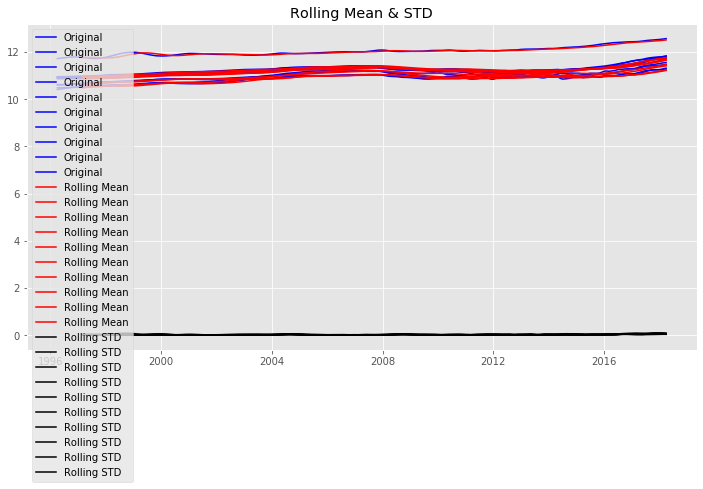

In [47]:
rolling_stats(log_df, 12)

* It appears some of the trend has been removed through log transformation

In [48]:
#Check stationarity statistics
dickey_fuller_test(log_df)

Dickey-Fuller Results: 76164 

Test Statistics          -0.344732
p-value                   0.918926
#Lags Used               16.000000
#Observations Used      248.000000
Critical Value (1%)      -3.456996
Critical Value (5%)      -2.873266
Critical Value (10%)     -2.573019
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics           0.927373
p-value                   0.993437
#Lags Used                3.000000
#Observations Used      261.000000
Critical Value (1%)      -3.455656
Critical Value (5%)      -2.872678
Critical Value (10%)     -2.572705
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics          -1.036520
p-value                   0.739713
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics          -0.361683
p-value                   0.916302
#Lags Used          

* Based off the new p-values there has only been a slight improvement over the original values. The data are still non-stationary and log transformations alone are not enough.

### Weighted Rolling Mean

* Subtracting the weighted rolling mean, in this case the exponentially weighted moving average from the data is another way to address removing unwanted trends from the time series.

In [49]:
#Calculated weighted moving average on df
ewm_df = top_10_df.ewm(halflife=2).mean()

In [50]:
#Drop rows with null values
ewm_df.dropna(inplace=True)

In [51]:
#Subtract the moving average from the df
df_minus_ewm = top_10_df - ewm_df

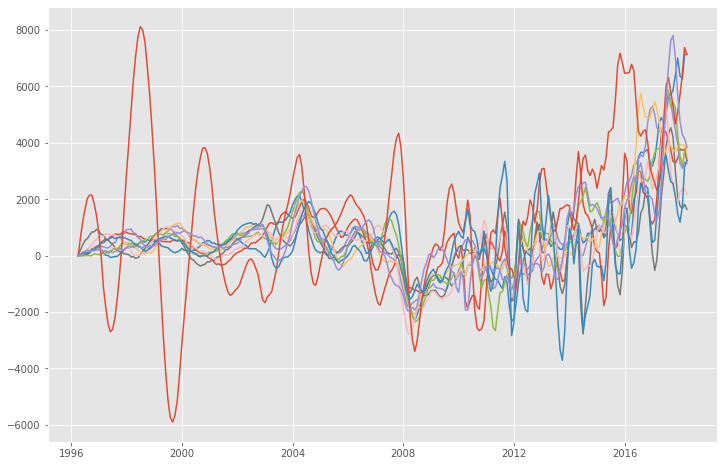

In [52]:
#Observe data
fig = plt.figure(figsize=(12, 8))
plt.plot(df_minus_ewm);

* The above graph shows that removing the ewm detrended most of the data up until 2012, where a clear positive trend is still seen.

In [53]:
#Perform Dickey Fuller test for stationarity
dickey_fuller_test(df_minus_ewm)

Dickey-Fuller Results: 76164 

Test Statistics           0.109248
p-value                   0.966687
#Lags Used               14.000000
#Observations Used      250.000000
Critical Value (1%)      -3.456781
Critical Value (5%)      -2.873172
Critical Value (10%)     -2.572969
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics          -0.153346
p-value                   0.943859
#Lags Used                4.000000
#Observations Used      260.000000
Critical Value (1%)      -3.455754
Critical Value (5%)      -2.872721
Critical Value (10%)     -2.572728
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics          -1.582344
p-value                   0.492456
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics          -2.010915
p-value                   0.281808
#Lags Used          

* Removing the ewm did seem to move the data in the right direction toward being more stationary than the log transformed data. P-values range between 0.10 and 0.97. Still not very positive Dickey Fuller results, but better than before.


* The positive trend post 2012 after removing the ewm seems to indicate the data could benefit from both log transformations as well as the removal of the ewm.

### Log minus EWM

In [54]:
df_log_minus_ewm = top_10_df.apply(np.log) - top_10_df.apply(np.log).ewm(halflife=2).mean()

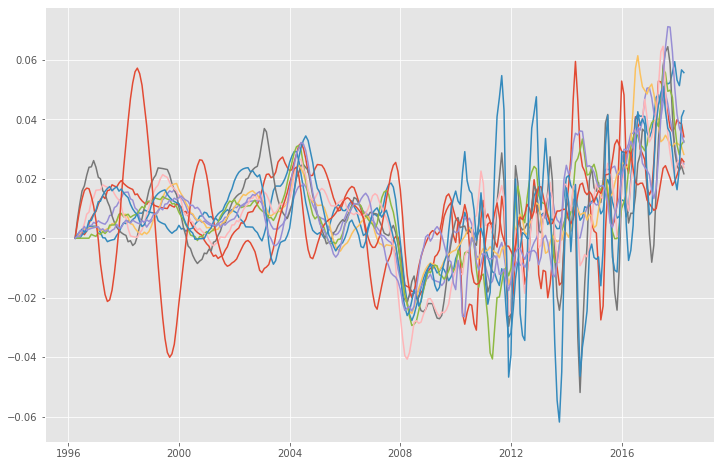

In [55]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df_log_minus_ewm);

In [56]:
df_log_minus_ewm.dropna(inplace=True)

In [57]:
dickey_fuller_test(df_log_minus_ewm)

Dickey-Fuller Results: 76164 

Test Statistics          -0.737520
p-value                   0.836790
#Lags Used               14.000000
#Observations Used      250.000000
Critical Value (1%)      -3.456781
Critical Value (5%)      -2.873172
Critical Value (10%)     -2.572969
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics          -0.747222
p-value                   0.834136
#Lags Used               10.000000
#Observations Used      254.000000
Critical Value (1%)      -3.456360
Critical Value (5%)      -2.872987
Critical Value (10%)     -2.572870
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics          -1.697116
p-value                   0.432599
#Lags Used               13.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics          -2.685623
p-value                   0.076559
#Lags Used          

* Again, the data are getting closer to being stationary, with p-values ranging between 0.03 and 0.83. 



* ###As seen previously, there's a clear difference in the trend of home prices pre and post 2008. The latter years show an exponential rise in home values, where as the former years display a gradual upward trend. It may be prudent at this time to focus in on home prices from 2008 onward to isolate the more recent trend for more accurate forecasting.

### Differencing

The last thing to try in order to make the data stationary is differencing. If seasonality is the issue keeping this data from becoming stationary, differencing will help. 

In [58]:
df_all_diff = df_log_minus_ewm.diff()
df_all_diff.dropna(inplace=True)

dickey_fuller_test(df_all_diff)

Dickey-Fuller Results: 76164 

Test Statistics        -7.621731e+00
p-value                 2.119656e-11
#Lags Used              1.300000e+01
#Observations Used      2.500000e+02
Critical Value (1%)    -3.456781e+00
Critical Value (5%)    -2.873172e+00
Critical Value (10%)   -2.572969e+00
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics        -6.324247e+00
p-value                 3.013575e-08
#Lags Used              9.000000e+00
#Observations Used      2.540000e+02
Critical Value (1%)    -3.456360e+00
Critical Value (5%)    -2.872987e+00
Critical Value (10%)   -2.572870e+00
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics          -4.436032
p-value                   0.000256
#Lags Used               12.000000
#Observations Used      251.000000
Critical Value (1%)      -3.456674
Critical Value (5%)      -2.873125
Critical Value (10%)     -2.572944
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics          -5.382951
p-value                   0

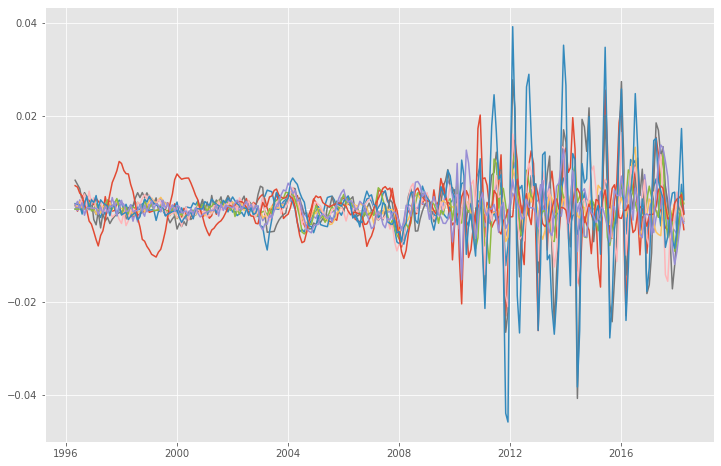

In [59]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df_all_diff);

* The results from the Dickey Fuller test show that the data are finally stationary. This is reflected by all of the p-values falling below the 0.05 threshold. The null hypothesis is now the data are ready for modeling.

## Log minus EWM post 2012

In [60]:
top_10_df.tail()

Zipcode      76164   76114   76117  76105   76010   76111  76119   76107  \
2017-12-01   97600  125700  130900  76400  127000  118200  91000  272400   
2018-01-01   99500  127700  131600  76800  128700  118900  92300  275400   
2018-02-01  101000  130200  132700  77400  130300  119900  93400  278800   
2018-03-01  102600  134000  134300  78300  131900  121900  94400  282800   
2018-04-01  103600  137000  135600  78800  133100  123700  95100  285500   

Zipcode     76104   76103  
2017-12-01  76000  121100  
2018-01-01  76200  122100  
2018-02-01  77500  123400  
2018-03-01  80200  125000  
2018-04-01  81800  126300

In [61]:
#Create a new df of home values between 2008 and 2018
top_10_df_2012_up = top_10_df['2012-01-01': '2018-04-01']
top_10_df_2012_up.head()

Zipcode     76164  76114  76117  76105  76010  76111  76119   76107  76104  \
2012-01-01  59400  67500  73500  51100  71500  61600  55300  170600  57400   
2012-02-01  59400  67400  73400  52600  72000  62200  56000  169900  59700   
2012-03-01  60200  67700  73300  54300  72600  63300  56700  170400  61400   
2012-04-01  61000  67900  73200  54400  73000  64100  56600  171800  60300   
2012-05-01  61000  68100  72800  53700  73400  64200  56100  172800  58100   

Zipcode     76103  
2012-01-01  67100  
2012-02-01  67300  
2012-03-01  67400  
2012-04-01  67400  
2012-05-01  67300

In [62]:
df_log_minus_ewm_2012 = top_10_df_2012_up.apply(np.log) - top_10_df_2012_up.apply(np.log).ewm(halflife=2).mean()

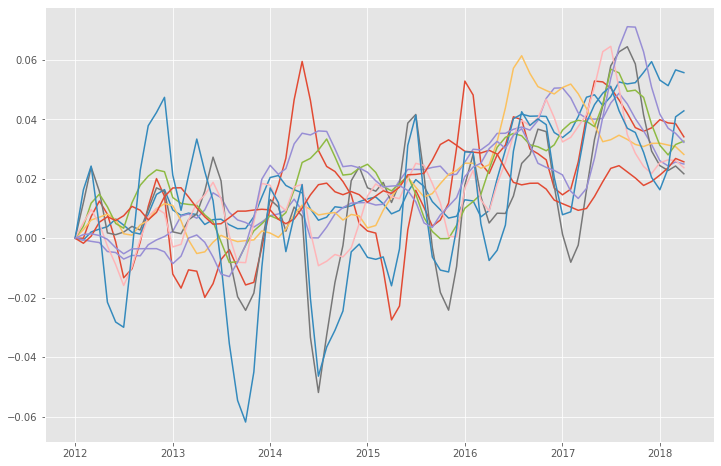

In [63]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df_log_minus_ewm_2012);

In [64]:
dickey_fuller_test(df_log_minus_ewm_2012)

Dickey-Fuller Results: 76164 

Test Statistics         -1.137258
p-value                  0.699988
#Lags Used              11.000000
#Observations Used      64.000000
Critical Value (1%)     -3.536928
Critical Value (5%)     -2.907887
Critical Value (10%)    -2.591493
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics         -0.278154
p-value                  0.928542
#Lags Used               4.000000
#Observations Used      71.000000
Critical Value (1%)     -3.526005
Critical Value (5%)     -2.903200
Critical Value (10%)    -2.588995
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics         -2.234573
p-value                  0.193938
#Lags Used               8.000000
#Observations Used      67.000000
Critical Value (1%)     -3.531955
Critical Value (5%)     -2.905755
Critical Value (10%)    -2.590357
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics         -1.925390
p-value                  0.320213
#Lags Used               4.000000
#Observat

In [65]:
df_2012_diff = df_log_minus_ewm_2012.diff()
df_2012_diff.dropna(inplace=True)

In [66]:
dickey_fuller_test(df_2012_diff)

Dickey-Fuller Results: 76164 

Test Statistics         -3.796758
p-value                  0.002941
#Lags Used              10.000000
#Observations Used      64.000000
Critical Value (1%)     -3.536928
Critical Value (5%)     -2.907887
Critical Value (10%)    -2.591493
dtype: float64


Dickey-Fuller Results: 76114 

Test Statistics         -4.577791
p-value                  0.000142
#Lags Used               3.000000
#Observations Used      71.000000
Critical Value (1%)     -3.526005
Critical Value (5%)     -2.903200
Critical Value (10%)    -2.588995
dtype: float64


Dickey-Fuller Results: 76117 

Test Statistics         -1.324289
p-value                  0.617988
#Lags Used               7.000000
#Observations Used      67.000000
Critical Value (1%)     -3.531955
Critical Value (5%)     -2.905755
Critical Value (10%)    -2.590357
dtype: float64


Dickey-Fuller Results: 76105 

Test Statistics         -4.579171
p-value                  0.000141
#Lags Used              11.000000
#Observat

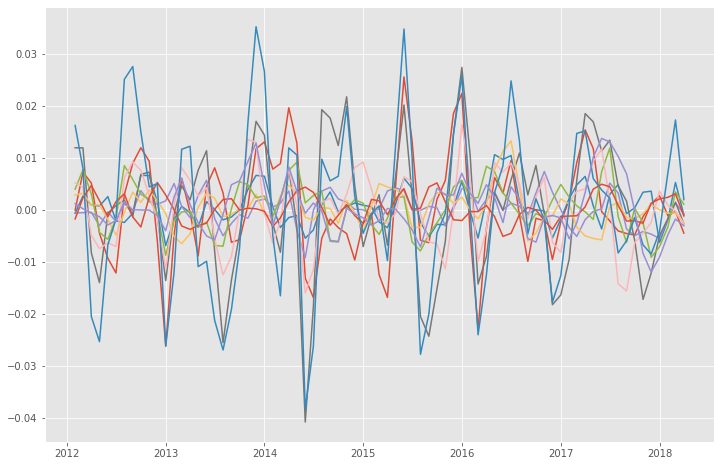

In [67]:
fig = plt.figure(figsize=(12, 8))
plt.plot(df_2012_diff);

p-values are still quite high meaning the data aren't stationary at this time. 
Try to apply differencing to the function

# Step 5: ARIMA Modeling

### Train test split

In [121]:
top_10_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76164   265 non-null    int32
 1   76114   265 non-null    int32
 2   76117   265 non-null    int32
 3   76105   265 non-null    int32
 4   76010   265 non-null    int32
 5   76111   265 non-null    int32
 6   76119   265 non-null    int32
 7   76107   265 non-null    int32
 8   76104   265 non-null    int32
 9   76103   265 non-null    int32
dtypes: int32(10)
memory usage: 22.4 KB


In [122]:
train_data = []
for col in top_10_df.columns:
    train = top_10_df[col]['1996-04-01':'2015-04-01']
    train_data.append(train)

train_df = pd.DataFrame(train_data).transpose()

train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 1996-04-01 to 2015-04-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76164   229 non-null    int32
 1   76114   229 non-null    int32
 2   76117   229 non-null    int32
 3   76105   229 non-null    int32
 4   76010   229 non-null    int32
 5   76111   229 non-null    int32
 6   76119   229 non-null    int32
 7   76107   229 non-null    int32
 8   76104   229 non-null    int32
 9   76103   229 non-null    int32
dtypes: int32(10)
memory usage: 20.7 KB


In [123]:
train_df.head()

76164  76114  76117  76105  76010  76111  76119   76107  76104  \
1996-04-01  40300  56000  56700  33100  56100  52300  40500  122600  35500   
1996-05-01  40400  56000  56800  33600  56200  52300  40600  124100  35600   
1996-06-01  40400  56000  56800  34100  56300  52300  40700  125700  35700   
1996-07-01  40500  56100  57000  34600  56500  52300  40800  127200  35800   
1996-08-01  40500  56200  57100  35000  56600  52300  41000  128700  35800   

            76103  
1996-04-01  55000  
1996-05-01  55100  
1996-06-01  55300  
1996-07-01  55400  
1996-08-01  55600

In [124]:
test_data = []
for col in top_10_df.columns:
    test = top_10_df[col]['2015-04-01':'2018-04-01']
    test_data.append(test)

test_df = pd.DataFrame(test_data).transpose()
test_df.head()

76164  76114  76117  76105  76010  76111  76119   76107  76104  \
2015-04-01  63000  78900  80900  56100  78900  79000  61100  205000  54600   
2015-05-01  62700  79300  81900  56900  79800  79800  61400  206900  55200   
2015-06-01  64400  80300  83000  59000  80700  80700  62300  209600  57900   
2015-07-01  65700  81300  83800  60200  81000  80700  63300  211500  59500   
2015-08-01  65600  81700  84600  59500  81200  80300  63900  213500  58200   

            76103  
2015-04-01  79600  
2015-05-01  80200  
2015-06-01  80600  
2015-07-01  80700  
2015-08-01  80300

In [125]:
test_df.shape

(37, 10)

### Auto Arima

#### 76164

In [68]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [85]:
top_10_df_diff = top_10_df.diff(periods=1).dropna()

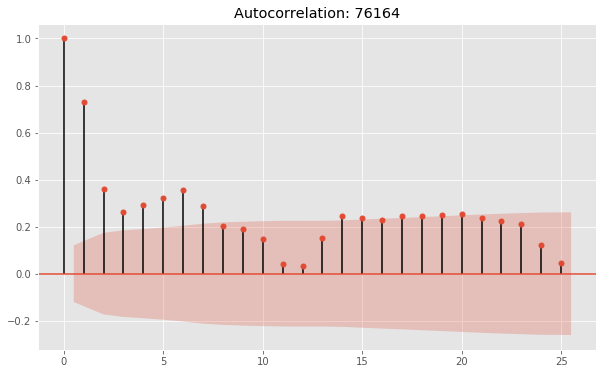

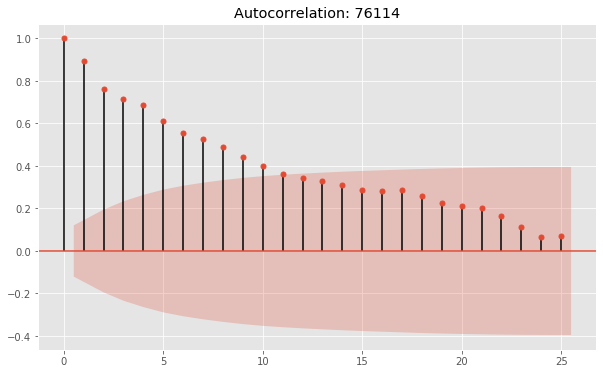

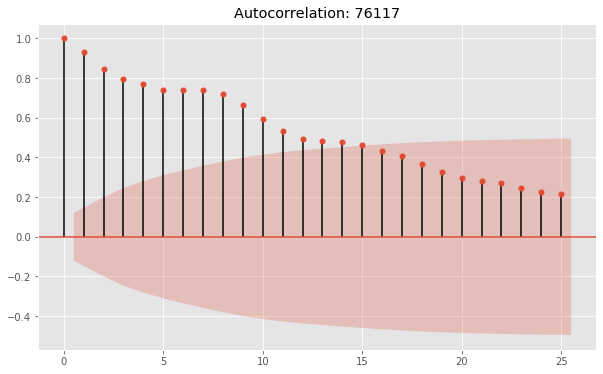

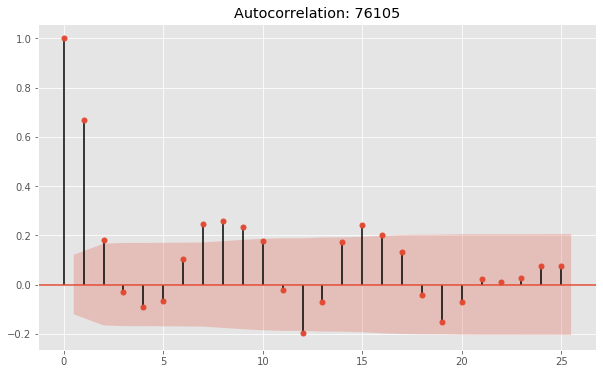

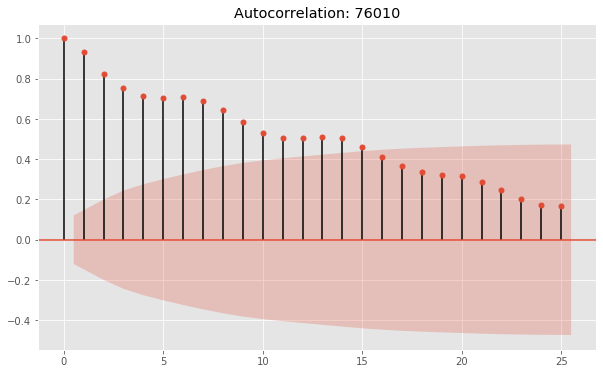

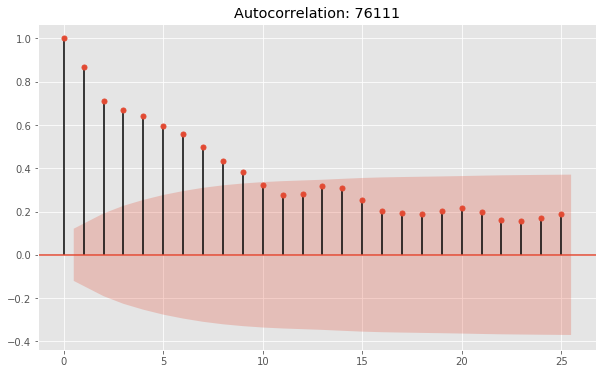

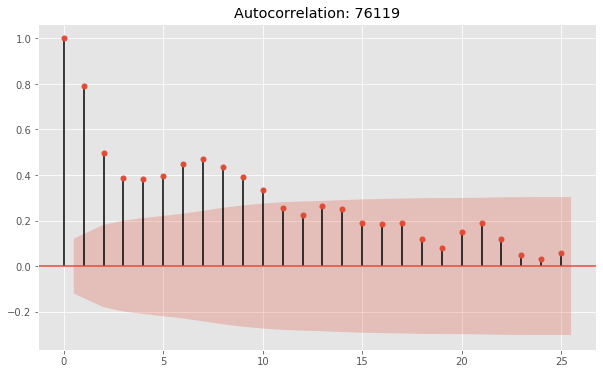

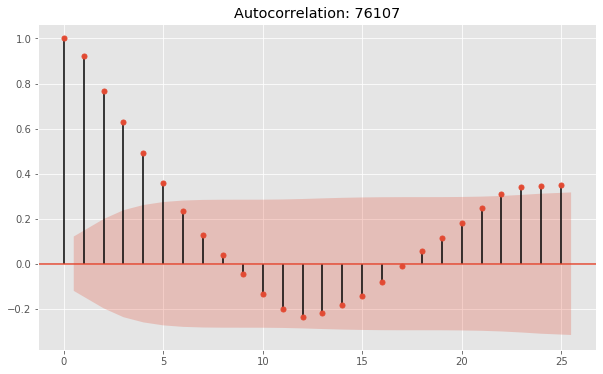

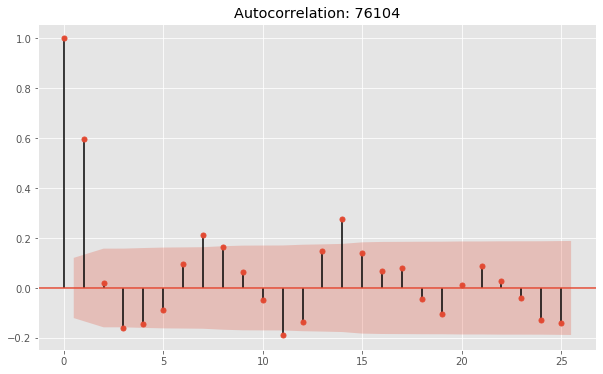

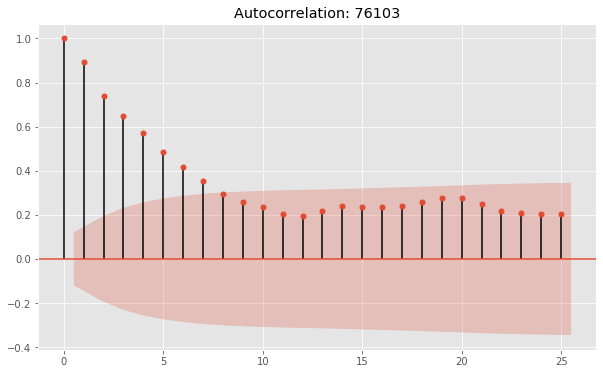

In [86]:
for col in top_10_df_diff.columns:
    title = (f'Autocorrelation: {col}')
    lags = 25
    plot_acf(top_10_df_diff[col],title=title,lags=lags);

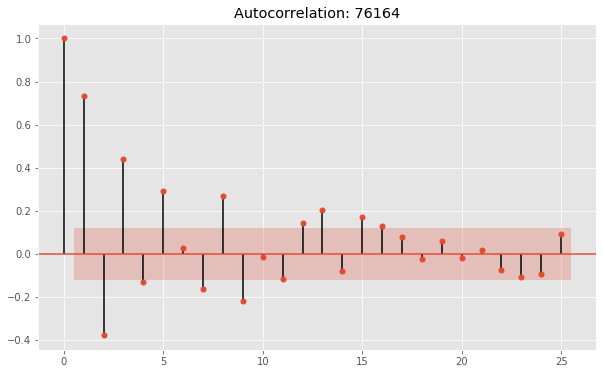

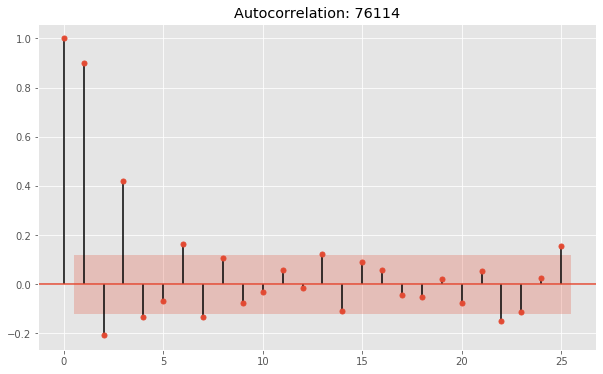

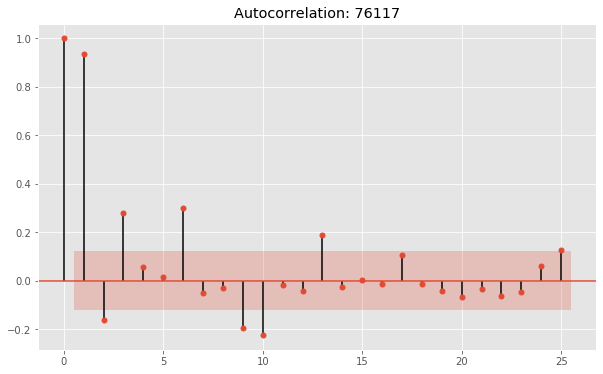

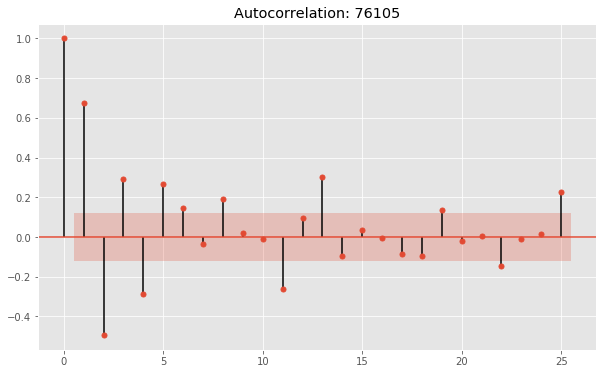

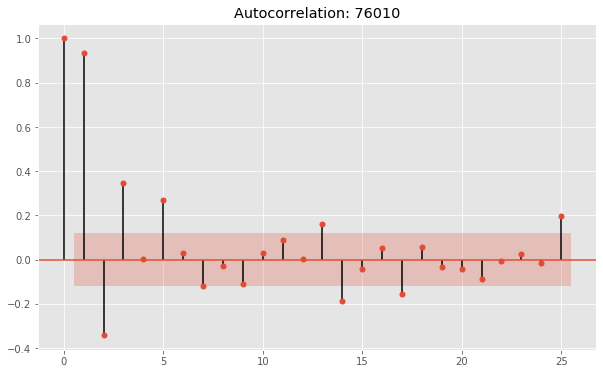

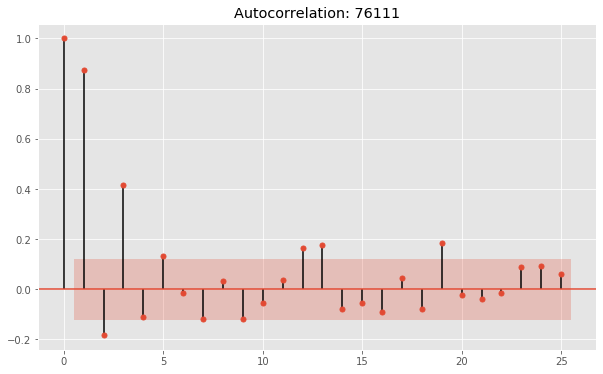

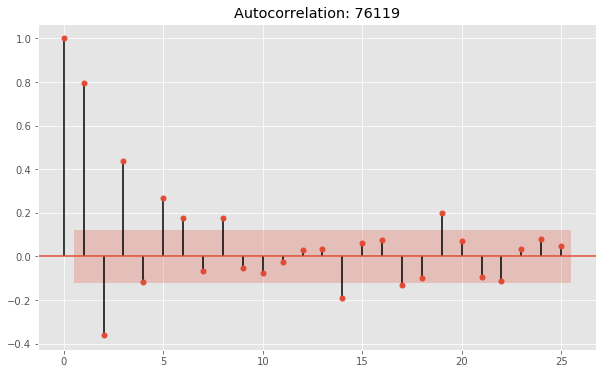

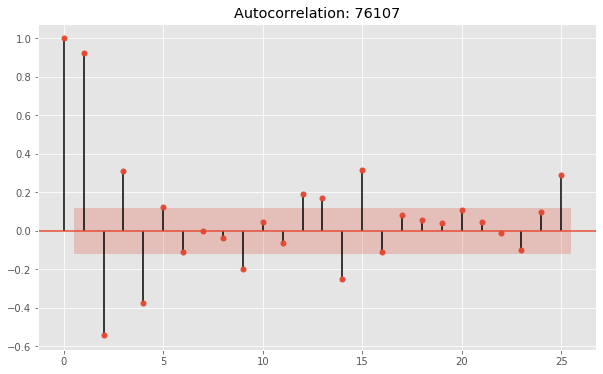

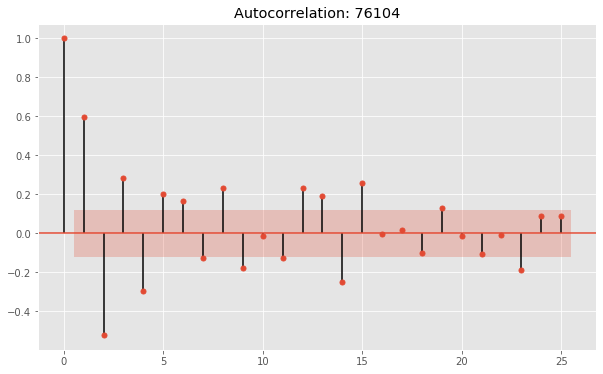

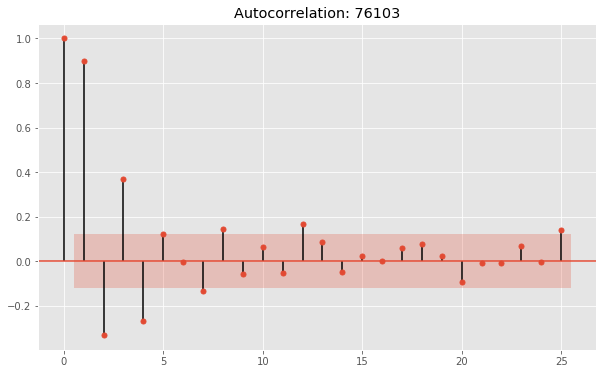

In [87]:
for col in top_10_df_diff.columns:
    title = (f'Autocorrelation: {col}')
    lags = 25
    plot_pacf(top_10_df_diff[col],title=title,lags=lags);

In [97]:
!pip install pmdarima

In [98]:
from pmdarima.arima import auto_arima

In [126]:
top_10_df.head()

Zipcode     76164  76114  76117  76105  76010  76111  76119   76107  76104  \
1996-04-01  40300  56000  56700  33100  56100  52300  40500  122600  35500   
1996-05-01  40400  56000  56800  33600  56200  52300  40600  124100  35600   
1996-06-01  40400  56000  56800  34100  56300  52300  40700  125700  35700   
1996-07-01  40500  56100  57000  34600  56500  52300  40800  127200  35800   
1996-08-01  40500  56200  57100  35000  56600  52300  41000  128700  35800   

Zipcode     76103  
1996-04-01  55000  
1996-05-01  55100  
1996-06-01  55300  
1996-07-01  55400  
1996-08-01  55600

In [132]:
arima_76164 = auto_arima(top_10_df['76164'], test='adf', start_p=0, d=1, start_q=0, max_p=6,
                        max_d=3, max_q=7, start_Q=0, max_P=6, max_D=3, D=1, 
                        max_Q=7, m=12, seasonal=True, error_action='warn', 
                        trace=True, stepwise=True, random_state=42, n_fits=500,
                        maxiter=500)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=4151.384, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4190.896, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4087.258, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4066.150, Time=0.98 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4111.202, Time=0.15 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4068.057, Time=1.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4068.071, Time=2.21 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4073.312, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4068.434, Time=8.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4145.815, Time=0.66 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=4066.015, Time=1.57 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=4112.526, Time=0.32 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=4067.825, Time=2.20 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=4067.862, Time=4.17 sec
 ARIMA(1,1,1)(1,1,0

In [133]:
arima_76164.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  265
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 12)   Log Likelihood               -2017.769
Date:                              Mon, 10 Aug 2020   AIC                           4053.537
Time:                                      15:04:02   BIC                           4085.302
Sample:                                           0   HQIC                          4066.319
                                              - 265                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.0356      1.335      1.525      0.127      -0.581       4.653
ar.L1          0.0866      0.035      2.507      0.012       0.019       0.154
ar.L2          0.9022      0.034     26.744      0.000       0.836       0.968
ma.L1          0.7188      0.024     29.613      0.000       0.671       0.766
ma.L2         -0.8188      0.019    -43.889      0.000      -0.855      -0.782
ma.L3         -0.6914      0.021    -32.456      0.000      -0.733      -0.650
ar.S.L12       0.1309      0.047      2.780      0.005       0.039       0.223
ma.S.L12      -0.7655      0.061    -12.566      0.000      -0.885      -0.646
sigma2      1.886e+05   1.19e+04     15.802      0.000    1.65e+05    2.12e+05
===================================================================================
Ljung-Box (Q):                       84.24   Jarque-Bera (JB):               627.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.97
Prob(H) (two-sided):                  0.17   Kurtosis:                        10.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [134]:
predict_76164 = pd.DataFrame(arima_76164.predict(n_periods = 37), index=test_df['76164'].index)
predict_76164.columns = ['76164_predicted_price']

In [130]:
predict_76164

76164_predicted_price
2015-04-01           62409.849152
2015-05-01           62216.225233
2015-06-01           61984.760804
2015-07-01           61919.660976
2015-08-01           62017.675396
2015-09-01           61924.788186
2015-10-01           61880.306792
2015-11-01           61615.711173
2015-12-01           61438.336414
2016-01-01           61351.158906
2016-02-01           61181.570653
2016-03-01           60829.091302
2016-04-01           60753.022517
2016-05-01           60556.336569
2016-06-01           60328.387788
2016-07-01           60276.971904
2016-08-01           60331.592769
2016-09-01           60243.071732
2016-10-01           60184.602377
2016-11-01           59985.270245
2016-12-01           59802.674569
2017-01-01           59741.902516
2017-02-01           59674.863281
2017-03-01           59506.864720
2017-04-01           59490.258543
2017-05-01           59321.152272
2017-06-01           59099.346021
2017-07-01           59074.156993
2017-08-01           59130.385502
2017-09-01           59064.381691
2017-10-01           59010.876137
2017-11-01           58838.114467
2017-12-01           58661.519331
2018-01-01           58621.121708
2018-02-01           58571.475488
2018-03-01           58438.722973
2018-04-01           58434.874620

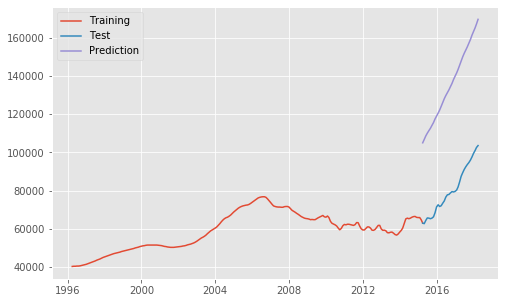

In [135]:
plt.figure(figsize=(8,5))
plt.plot(train_df['76164'], label="Training")
plt.plot(test_df['76164'], label='Test')
plt.plot(predict_76164, label='Prediction')
plt.legend(loc='Lest Corner');

#### 76164 post 2011

In [105]:
top_10_df_2012_up.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2012-01-01 to 2018-04-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76164   76 non-null     int32
 1   76114   76 non-null     int32
 2   76117   76 non-null     int32
 3   76105   76 non-null     int32
 4   76010   76 non-null     int32
 5   76111   76 non-null     int32
 6   76119   76 non-null     int32
 7   76107   76 non-null     int32
 8   76104   76 non-null     int32
 9   76103   76 non-null     int32
dtypes: int32(10)
memory usage: 6.1 KB


In [136]:
train_data_2012 = []
for col in top_10_df_2012_up.columns:
    train = top_10_df_2012_up[col]['2012-01-01':'2016-01-01']
    train_data_2012.append(train)

train_df = pd.DataFrame(train_data_2012).transpose()

train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2012-01-01 to 2016-01-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76164   49 non-null     int32
 1   76114   49 non-null     int32
 2   76117   49 non-null     int32
 3   76105   49 non-null     int32
 4   76010   49 non-null     int32
 5   76111   49 non-null     int32
 6   76119   49 non-null     int32
 7   76107   49 non-null     int32
 8   76104   49 non-null     int32
 9   76103   49 non-null     int32
dtypes: int32(10)
memory usage: 3.5 KB


In [137]:
test_data_2012 = []
for col in top_10_df_2012_up.columns:
    test = top_10_df_2012_up[col]['2016-01-01':'2018-04-01']
    test_data_2012.append(test)

test_df = pd.DataFrame(test_data_2012).transpose()
test_df.head()

76164  76114  76117  76105  76010  76111  76119   76107  76104  \
2016-01-01  71500  83000  89000  58400  85700  81100  64700  229000  59200   
2016-02-01  72600  83400  90500  59700  86600  81700  65700  231700  59900   
2016-03-01  71700  83200  91600  59200  87300  82400  65400  234400  58600   
2016-04-01  72100  83700  93000  58800  88300  83900  65400  237500  57700   
2016-05-01  73400  85300  94700  59200  90200  85600  66500  240000  57800   

            76103  
2016-01-01  83500  
2016-02-01  84600  
2016-03-01  85600  
2016-04-01  87100  
2016-05-01  88500

In [138]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2016-01-01 to 2018-04-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   76164   28 non-null     int32
 1   76114   28 non-null     int32
 2   76117   28 non-null     int32
 3   76105   28 non-null     int32
 4   76010   28 non-null     int32
 5   76111   28 non-null     int32
 6   76119   28 non-null     int32
 7   76107   28 non-null     int32
 8   76104   28 non-null     int32
 9   76103   28 non-null     int32
dtypes: int32(10)
memory usage: 2.6 KB


In [141]:
arima_76164_2012 = auto_arima(train_df['76164'], test='adf', start_p=0, 
                              d=1, start_q=0, max_p=6,max_d=3, max_q=7, start_Q=0, 
                              max_P=6, max_D=3, D=1, max_Q=7, m=12, seasonal=True, 
                              error_action='warn', trace=True, stepwise=True, 
                              random_state=42, n_fits=500,maxiter=500)



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=633.903, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=638.933, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=634.677, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=634.281, Time=0.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=642.163, Time=0.14 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=633.596, Time=0.49 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=634.694, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=636.507, Time=0.16 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=3.21 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=633.587, Time=0.87 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=634.974, Time=0.09 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.53 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, T

In [142]:
arima_76164_2012.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   49
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -312.793
Date:                              Mon, 10 Aug 2020   AIC                            633.587
Time:                                      15:09:28   BIC                            639.921
Sample:                                           0   HQIC                           635.797
                                               - 49                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0594      0.043      1.381      0.167      -0.025       0.144
ar.S.L12      -0.8498      0.662     -1.284      0.199      -2.147       0.448
ma.S.L12       0.7957      0.752      1.058      0.290      -0.679       2.270
sigma2       1.92e+06      8e-07    2.4e+12      0.000    1.92e+06    1.92e+06
===================================================================================
Ljung-Box (Q):                       58.76   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.01   Prob(JB):                         0.67
Heteroskedasticity (H):               3.15   Skew:                            -0.33
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+28. Standard errors may be unstable.
"""

In [143]:
predict_76164_2012 = pd.DataFrame(arima_76164_2012.predict(n_periods = 28), index=test_df['76164'].index)
predict_76164_2012.columns = ['76164_predicted_price']

In [144]:
predict_76164_2012

76164_predicted_price
2016-01-01           71726.547922
2016-02-01           70854.530686
2016-03-01           69475.325935
2016-04-01           69522.903120
2016-05-01           71140.559312
2016-06-01           72246.397021
2016-07-01           72168.406055
2016-08-01           72016.683742
2016-09-01           72448.175290
2016-10-01           73206.507792
2016-11-01           75036.027071
2016-12-01           76252.929195
2017-01-01           76336.622275
2017-02-01           75273.808965
2017-03-01           73537.175812
2017-04-01           73289.382558
2017-05-01           74977.017447
2017-06-01           76247.859756
2017-07-01           76151.164897
2017-08-01           75873.432045
2017-09-01           76193.178386
2017-10-01           76901.938291
2017-11-01           78961.319676
2017-12-01           81778.531215
2018-01-01           81983.626348
2018-02-01           81082.956896
2018-03-01           79650.076428
2018-04-01           79653.297261

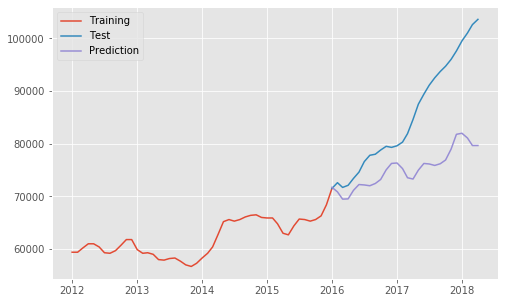

In [145]:
plt.figure(figsize=(8,5))
plt.plot(train_df['76164'], label="Training")
plt.plot(test_df['76164'], label='Test')
plt.plot(predict_76164_2012, label='Prediction')
plt.legend(loc='Lest Corner');

### Sarimax

#### 76164

In [67]:
p = range(0, 3)
d = range(1, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top_10_df['76164'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4175.261603641225
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3897.7125505115764


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3699.252013065444
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4253.675403758128


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3837.249573801393


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3587.8377181486276
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3910.5283467593435


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3892.464650931524


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3702.397738128161


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3891.969708872961


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3785.699943805267


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3581.477989937084


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3712.0166177989727


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3711.4708985880425


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3699.498152390569


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3587.51373148778


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3589.2887472080192


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3562.5059217679063


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3996.003161442073


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3700.953984478241


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3503.6124972622015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4071.4879786899783


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3687.4275411355716


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3404.687057745692


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3789.891985980371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3695.3509838958635


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3504.3963921187137


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3780.8395008136868


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3664.9879993461245


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3402.823112724067


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3563.059065794073


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3544.786003178533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3506.383865006882


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3508.0324314955005


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3485.4618175122337


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3499.1054649147404


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3890.5088647383727


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3592.895653605004


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3402.2640247934532


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3963.0720514143045


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3628.450100520795


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3305.7360815058523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3732.0795921273366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3637.0570061988983


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3401.4105884576347


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3740.6725834838444


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3581.3638903322103


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3306.5603009297956


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3499.3901410648004


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3459.203783025716


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3402.876146422621


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3472.002142212289


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3460.2668528542354


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3354.3055051779984
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4085.448269677625


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3783.890316275846


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3544.9743714426118
ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4171.642917919355

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3754.7701666803696


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3515.0748297498317
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3810.7592951480606


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3777.9381353124195


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3532.9320103929267


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3809.838335042842


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3698.0647686705615


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3507.7287689202294


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3595.6564804334075


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3560.016586843035


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3574.3585749048816


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3535.0370177521045


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3517.9291883867522


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3486.8810981453207


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4008.6635056510167


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3671.6077944709114


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3480.5150219197367


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4087.5289472383915


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3702.0134132775083


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3392.3837495542366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3795.546612490745


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3669.7951753025827


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3482.0723614993276


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3780.588685255403


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3676.726567757839


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3381.893910628358


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3577.34557881571


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3520.906044536243


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3484.009107405225


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3525.3538834620695


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3499.1707788604162


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3377.4917444581433


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3968.0296567782066


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3621.0304036664506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3422.3332942457973


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =4037.3505636470277


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3655.744717542957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3354.447892507991


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3754.9343077947706


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3617.443953413318


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3423.2724268985253


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3752.871829579795


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3618.853259769565


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3461.9772443680176


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3529.460005396118


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3481.4193146626712


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3425.1032421340446


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3477.225037648377


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3454.2331407794272


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3383.62773806493
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4052.4169666413427


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3757.9378577521493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3527.653871350015
ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4141.8410730901705


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3747.587190284583


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3485.737449983544


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3766.7068003838053


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3754.471955822346


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3524.6238216970546


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3768.7800313573457


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3700.961215580694


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3484.81760299939


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3559.7078586434645


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3528.8638624108166


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3526.598496988974


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3486.3431021320966


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3483.1967760505777


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3469.195963051362
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3954.790068196193


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3633.5991250683346


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3443.689499381833


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4029.264282211472


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3660.4665529547156


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3363.804246467641


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3729.708538496797


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3628.264073960622


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3445.4839860408465


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3720.995229716901


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3635.9825885597875


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3356.8248556025374


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3515.263185153186


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3460.6898800123936


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3447.4815269082924


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3450.332122982698


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3431.014089049254


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3404.40780123881


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3892.0994605690903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3591.375072568164


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3402.572308818672


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3988.483443941568


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3597.3887673825975


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3301.893782052135


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3730.947850967104


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3638.8810310722583


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3400.6880375317414


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3719.1194671650583


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3578.6996595621163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3424.8675752478007


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3469.933814784403


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3441.8129388954067


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3415.1733569916164


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3461.661235280014


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3492.356551143247


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3454.060252738126
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =4077.021180751755


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3773.8228924096957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3540.2421143229976
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4163.4190944068905


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3748.774382465621


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3508.0327546292046


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3789.558157095266


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3769.5831180690875


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3527.466989424054


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3785.083274504397


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3693.083193533562


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3502.6416148498265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3576.9277960962495


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3540.0429715760874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3569.989425672834


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3517.2738358468587


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3497.991068405937


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3467.2453330686553


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =4008.968055475236


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3667.590993194919


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3479.6057549454817


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4087.4745953546208


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3725.606574738451


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3382.472600811383


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3764.2235883336543


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3666.2501410412224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3481.407648537134


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3752.050989891536


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3678.510746869061


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3374.030567857215


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3553.5960035225717


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3505.3701541521755


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3482.299103283563


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3495.417501791522


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3469.932106618461


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3448.6837786578667


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3932.893205498085


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3597.5837923806303


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3406.275658909358


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3997.841075029518


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3677.5975351820107


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3327.3832631394207


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3712.5086457831862


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3595.0516233399785


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3407.8910683067816


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3703.8564884109674


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3599.8710382709505


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3318.137927191572


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3497.6409850524815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3447.235464602918


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3409.873106250074


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3446.3968528600417


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3417.7191782352284


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3373.489201403597
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3975.859748837509


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3723.5546902065357


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3502.7519967509293
ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4062.3392733860373


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3706.3768144691103


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3450.5711071863243


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3703.0266446933465


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3683.1866785887987


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3497.678110639743


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3694.1932469034437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3642.999273820519


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3445.302635911823


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3508.50135352128


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3481.3584505853487


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3483.270853443469


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3423.606599832803


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3420.2668198698657


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3382.9878491145882
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3941.112334513676

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3635.309255974139


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3443.3582561595076


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =4014.058564957957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3648.081092766324


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3364.775619806459


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3684.426834881757


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3628.9660064722148


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3445.1130034000294


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3673.4422025067283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3618.9386559233426


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3356.1151739912057


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3486.4205857479947


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3445.070587143924


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3447.0705180115647


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3409.0020887751557


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3395.0465576454158


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3394.308562861314


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3891.0215492947145


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3592.006161514426


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3402.7400793624156


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3979.8291598095316


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3597.406626262531


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3305.529512920414


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3680.794739319905


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3640.753792795535


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3401.362170506135


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3672.281845687671


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3582.9590714772426


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3423.937481988043


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3456.9065527276316


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3423.6048610818325


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3441.8572276234445


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3404.7355905960585


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3409.5151177873477


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3381.3185514548063
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3951.2134916711484


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3681.0557391217603


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3459.477729971558
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =4033.4640707645203


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3665.389795848173


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3421.9099334093544


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3677.2689691019223


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3656.0466294193807


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3450.964539826542


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3672.0841133812883


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3605.598082027475


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3421.25750383549


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3479.9621894977095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3440.453877116549


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3437.8667395404113


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3417.8491264998465


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3394.889220587621


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3385.1860078484933


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3944.0851097183063


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3655.3548806311587


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3437.537669006544


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =4015.217814219877


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3646.3587549036765


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3390.618082574999


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3678.246292271856


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3653.8786980134228


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3435.109483748859


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3674.062784372092


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3607.474139289309


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3365.268246394527


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3474.990817338997


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3441.357725373663


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3437.090024678617


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3415.458901485055


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3394.7637398215074


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3351.9455418727593


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3921.139623877824


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3597.2702136736993


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3394.1193658462807


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3995.931062587914


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3613.4848342504697


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3328.5234752921797


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3667.310058172153


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3593.340603605846


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3396.1187953655403


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3668.5253602502535


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3582.7114086453566


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3319.0969864112303


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3459.414579900443


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3416.9535275425424


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3399.077944857796


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3399.174645111314


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3376.838441102943


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3309.857313176991


In [68]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 2)
pdqs    (0, 2, 2, 12)
aic           3301.89
Name: 149, dtype: object

In [95]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(top_10_df['76164'], 
                                        order=(2, 2, 7), 
                                        seasonal_order=(2, 2, 7, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2843      0.365     -0.779      0.436      -0.999       0.431
ar.L2         -0.7260      0.339     -2.144      0.032      -1.390      -0.062
ma.L1          0.4710      0.402      1.173      0.241      -0.316       1.258
ma.L2          0.3652      0.435      0.840      0.401      -0.487       1.218
ma.L3         -0.3262      0.217     -1.504      0.133      -0.751       0.099
ma.L4         -0.4254      0.244     -1.741      0.082      -0.904       0.053
ma.L5         -0.2724      0.234     -1.166      0.243      -0.730       0.185
ma.L6          0.0781      0.254      0.307      0.759      -0.420       0.576
ma.L7          0.1453      0.193      0.753      0.451      -0.233       0.523
ar.S.L12      -0.4252     13.727     -0.031      0.975     -27.330      26.480
ar.S.L24      -0.0590      9.024     -0.007      0.9

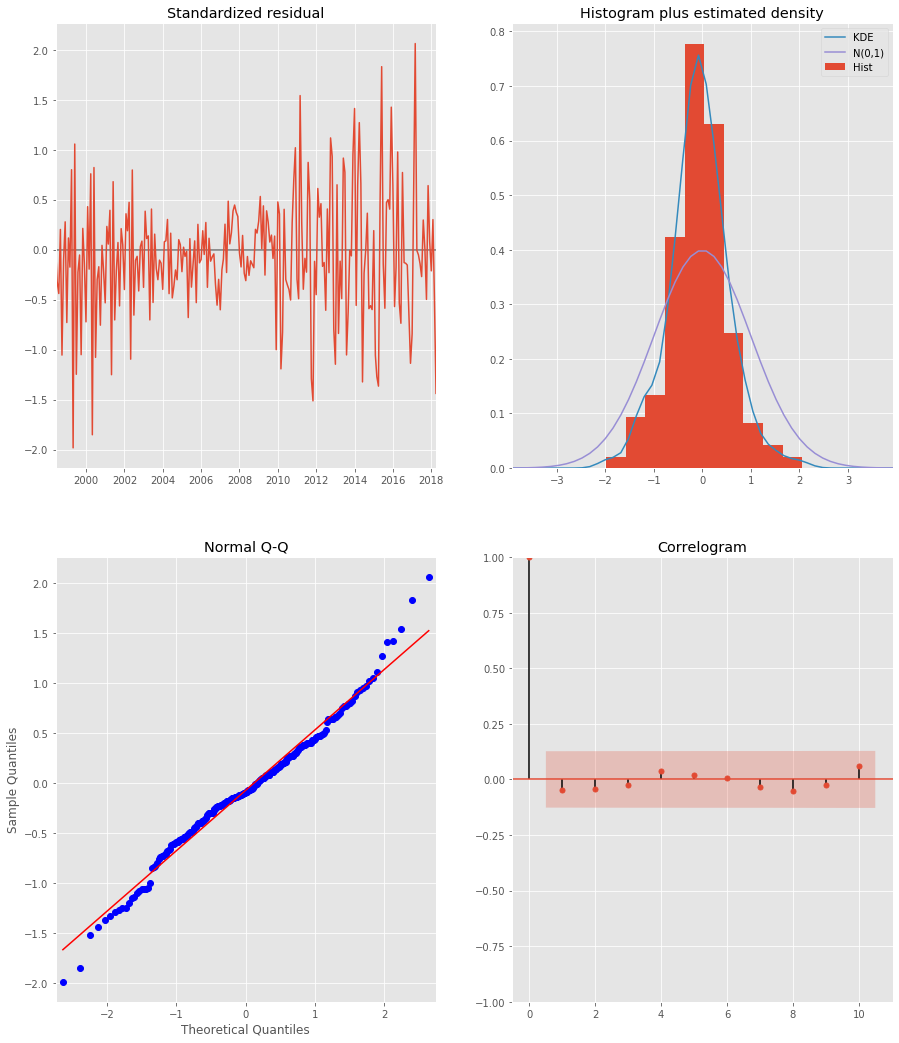

In [89]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [90]:
pred = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=False)
pred_conf = pred.conf_int()

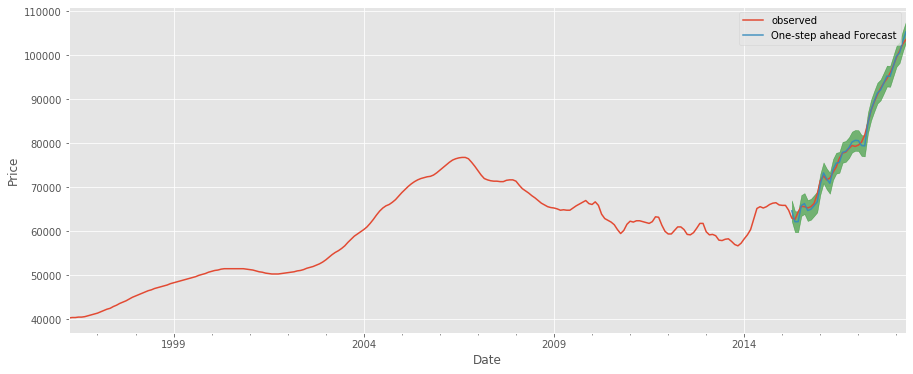

In [91]:

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = top_10_df['76164'].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [92]:
# Get the real and predicted values
forecasted_76164 = pred.predicted_mean
truth_76164 = top_10_df['76164']['2015-04-01':]

# Compute the mean square error
mse = ((forecasted_76164 - truth_76164) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 871200.15


In [93]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2015-04-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

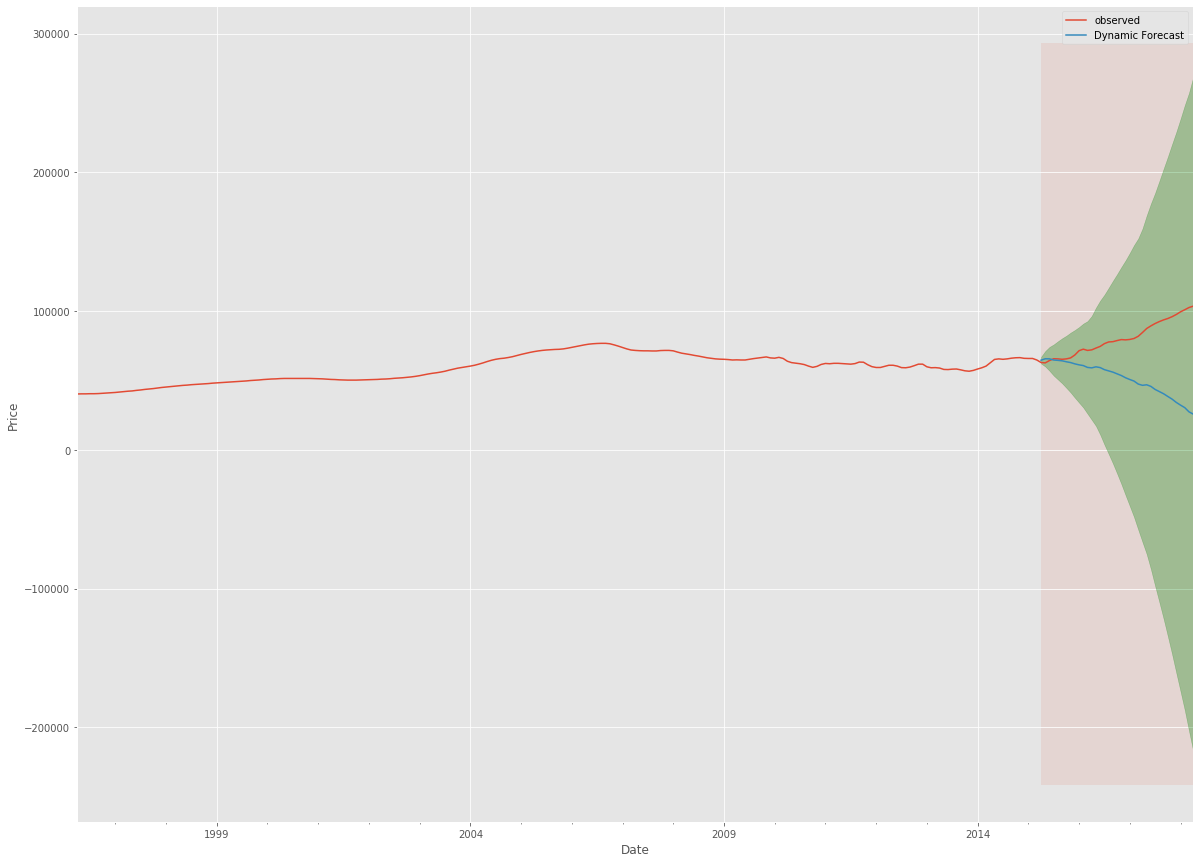

In [94]:

ax = top_10_df['76164'].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-04-01'), forecasted_76164.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

#### 76114

In [89]:
p = range(0, 3)
d = range(1, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top_10_df['76114'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =4005.6903809965115
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3813.5320129061497


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3634.545930483233
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =4023.832442791604


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3719.381945609869


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3475.5053238339874
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3829.538390258664


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3815.19282964665


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3636.411007450058
ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3738.3258276916545


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3702.0411423021396


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3455.4080938621305
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3646.9180574889956

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3648.856228502951


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3635.625229239265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3492.741965737049


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3490.301663902478


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3475.3943717154098


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3817.8442950576505


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3587.880225874309


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3418.719378202364


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3841.277500270304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3538.1209207997836


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3276.0884454441225


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3636.575081133443


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3589.6736463561856


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3420.6892183004707


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3597.2809399688485


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3548.923191004


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3273.5488264043734


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3450.887877405574


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3449.1567778297076


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3422.6567117737654


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3363.5462747583488


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3347.3392458833596


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3275.530011971462


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3692.16533019532


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3473.025592786807


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3304.8739532083314


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3731.8231291818365


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3433.222906756741


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3182.1804230467333


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3547.5686711561493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3475.008104206483


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3306.8724410310715


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3525.778458969312


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3461.348087185435


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3182.5533944640792


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3358.661311172138


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3349.840462428593


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3308.4188657727072


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3287.3866027998265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3265.7256717055234


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3209.6836473073818
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3748.5808536716568


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3514.3060777058954


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3292.257526713218


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3800.996952289084


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3492.8108205457015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3278.601232113496
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3541.192610059781


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3504.575192221535


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3281.881200540305


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3515.0666359537527


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3474.322820506705


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3244.997576823519


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3346.2075648296523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3345.7977549658835


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3331.418314749313


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3294.29034691635


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3290.270118689547


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3273.8650893556655
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3719.435629087362


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3432.4886497925736


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3262.1860290958984


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3765.7185533197885


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3474.0126957516704


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3179.5895198934995


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3538.76009870271


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3431.679615578123


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3263.1285565833823


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3507.0547378869815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3454.1073111050446


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3160.2980250095316


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3345.667395421731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3345.289593635284


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3256.0684158243907


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3291.691227214214


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3287.5684249767605


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3244.86487585578
ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3689.3189159369867


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3388.761891238047


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3217.465233646015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3744.733250327065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3449.191851596076


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3137.716556543683


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3516.5276495038206


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3387.9901635732967


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3218.241847339419


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3496.33332370667


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3426.799516224877


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3120.4674745089524


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3321.9280356028257


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3267.991326114893


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3211.3872532836617


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3278.115758576737


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3269.181771545151


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3212.611590361197
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3739.66586249581


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3518.1631043408706


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3302.3666583985187


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3792.8887380522756


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3500.040154676737


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3269.8287561585835


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3526.2721482671723


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3519.2791942230097


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3297.7943500294377


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3493.540535781838


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3475.371189493108


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3271.1815388064656


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3337.2185203057975


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3337.396206991526


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3337.368125328855


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3272.6757058655394


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3269.3837738379016


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3268.597097394336
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3697.823569498837


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3434.8524550844113


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3268.6590416237195


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3744.9001135516446


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3454.402017320411


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3180.6453673125707


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3513.9289331845575


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3432.8558351278753


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3268.441241915485


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3477.3996003933216


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3438.25943314499


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3162.328656030431


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3329.0912433264184


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3285.4589377096377


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3265.6108690474507


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3260.5636797839006


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3243.495663448239


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3228.370968181971


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3681.1647238994574


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3406.729768629413


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3233.1320135642572


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3724.6977045409285


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3433.510184444826


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3160.7789208835884


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3508.2787830445823


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3468.5701469872847


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3233.8619862286314


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3478.7547899880547


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3416.5471418678444


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3138.556465767346


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3321.4913358325934


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3271.0386786257304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3225.9723570266306


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3261.3648766963506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3251.6424078633013


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3204.7277697599447
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3744.8292513163597


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3510.5221937913548


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3289.941292429191
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3792.934144780975


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3487.2143211909624


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3274.312626445735


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3526.156610837026


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3500.487762001165


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3281.5424431400015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3494.114348769224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3467.8362098050065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3241.07251992028


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3332.063450119972


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3331.6428485067268


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3330.8349661951693


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3277.0111873295277


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3272.6956177970037


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3234.801741205998
ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3717.4532500939667


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3432.626001068397


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3259.449127715231


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3765.706416726184


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3465.845495347815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3173.3220999476525


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3514.6090697495265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3432.2040126154598


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3255.048432607042


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3482.963571518557


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3457.0146999483386


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3156.9452530160233


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3322.639058094639


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3322.6563574197953


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3266.3566344635674


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3275.7913619422425


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3264.0930320225752


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3252.723048752313


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3684.594811001495


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3385.3151183370414


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3216.0998357615617


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3730.6784579860478


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3449.2744630439993


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3135.6919708014902


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3496.826916698533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3384.150506834183


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3216.3482796665885


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3471.179353109579


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3417.0666979785265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3116.968145557501


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3302.032087708492


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3251.9306273892385


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3212.5659669782544


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3253.343100368262


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3240.7142459049533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3228.0987745256043
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3707.86268322418


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3508.3746446878995


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3299.8248082325063


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3750.343524164329


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3482.4187731985935


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3254.902562919099


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3502.254030904534


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3501.9584868949723


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3295.6247931155076


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3456.3812284677842


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3444.4223625107707


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3236.3052654624853


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3317.0560884615716


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3317.7939947183845


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3273.7834899807553


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3240.9764252153855


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3237.7754450756715


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3237.6401086109854


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3707.0846369345686


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3436.3110348858118


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3267.3103976433226


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3745.148612822293


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3456.1114076688254


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3181.0045559995083


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3496.9894996935827


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3495.719261896838


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3267.7146024414287


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3450.2863654280836


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3438.7119103120513


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3163.8725638748147


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3315.095927206672


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3268.649122355324


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3267.8638045253065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3233.120369958


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3207.5889215127345


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3164.941847068698


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3681.9681573168673


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3404.274367073369


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3231.0529792169973


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3724.316484379645


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3427.2833814610403


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3174.1108278760157


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3485.4143988975147


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3463.4543214552327


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3231.571600919847


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3450.322155208941


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3415.672032113266


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3200.8421408387385


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3297.64718816606


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3246.4625639350807


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3257.009057601005


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3228.8008433915084


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3230.295582625412


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3253.1817128135863
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3689.430865850338


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3457.0640465779325


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3239.4484027985263
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3747.3738134430164


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3459.9117342056484


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3234.8569209024445


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3457.9283681686948


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3436.091120480814


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3237.1882484158796


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3439.0227536182656


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3419.201615588521


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3197.7985395710466


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3270.0991338178947


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3270.55724264911


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3267.3608412892486


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3214.7892035360464


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3210.249007834748


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3206.4721863098202


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3691.2821922414428


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3445.537809773311


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3224.061378693218


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3749.3091005390015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3450.842834762126


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3169.421010635786


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3459.30831065131


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3426.564861948531


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3226.0607278016746


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3440.921681787153


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3439.199624581316


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3152.7367791692286


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3271.486007038591


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3271.957737030437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3268.4612219554083


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3216.5369073370484


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3212.1003699734156


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3208.198161255308


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3677.603874363476


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3387.304289143952


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3212.762096610443


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3736.388310065133


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3429.2938140952174


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =3135.5462066116224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3461.265513375848


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3386.146885233809


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3214.5223471997847


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3442.746947574745


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3409.094050591144


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3118.251910313436


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3273.435545162244


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3273.9334745573633


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3255.7011084141695


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3218.0641529115333


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3213.6919156109134


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =3192.709639408387


In [90]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 2, 2)
pdqs    (1, 2, 2, 12)
aic           3116.97
Name: 209, dtype: object

In [91]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(top_10_df['76114'], 
                                        order=(1, 2, 2), 
                                        seasonal_order=(1, 2, 2, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4961      0.161      3.077      0.002       0.180       0.812
ma.L1         -0.4008      0.169     -2.366      0.018      -0.733      -0.069
ma.L2         -0.2548      0.034     -7.482      0.000      -0.322      -0.188
ar.S.L12      -0.3737      0.652     -0.573      0.567      -1.651       0.904
ma.S.L12      -0.4061      0.658     -0.617      0.537      -1.695       0.883
ma.S.L24      -0.3232      0.500     -0.646      0.518      -1.303       0.657
sigma2       2.24e+05   1.73e+04     12.932      0.000     1.9e+05    2.58e+05


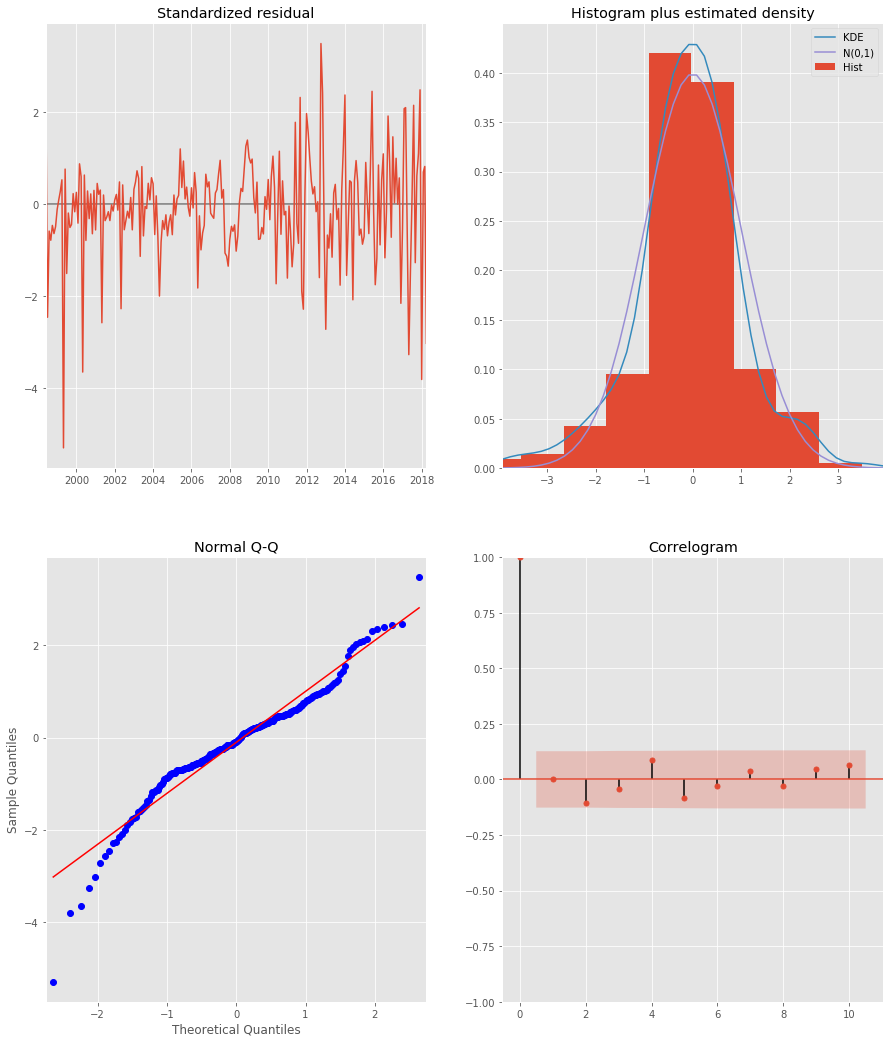

In [101]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

#### 76164 post 2011

In [69]:
p = range(0, 4)
d = range(1, 3)
q = range(0, 4)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top_10_df_2012_up['76164'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency info

ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1089.9462915737024
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =868.7618559242406
ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =655.3667882720613


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 3, 12)12 : AIC Calculated =444.62736320558815
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =942.4480884451875


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =685.2596825625097


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =451.4371519405962


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 3, 12)12 : AIC Calculated =259.48852197412344
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =877.2952588470408


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =861.8096416322996


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =659.0755610719093


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 0) x (1, 1, 3, 12)12 : AIC Calculated =445.1795527476511
ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =701.0753645324813


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =685.7236958152849


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =453.29452396764435


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (1, 2, 3, 12)12 : AIC Calculated =246.51042893716956
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =674.4323898464422


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =671.4345971939892


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =657.2333506792818


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 0) x (2, 1, 3, 12)12 : AIC Calculated =447.9465678443302
ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =470.6734250399265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =490.55830821929766


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =450.7427456473283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (2, 2, 3, 12)12 : AIC Calculated =261.9922414865307
ARIMA (0, 1, 0) x (3, 1, 0, 12)12 : AIC Calculated =461.96865048024597


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (3, 1, 1, 12)12 : AIC Calculated =460.4161852682843


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 0) x (3, 1, 2, 12)12 : AIC Calculated =463.4448340800169


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (3, 1, 3, 12)12 : AIC Calculated =445.69954247069785
ARIMA (0, 1, 0) x (3, 2, 0, 12)12 : AIC Calculated =258.26826515918754


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (3, 2, 1, 12)12 : AIC Calculated =261.40061317135286


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (3, 2, 2, 12)12 : AIC Calculated =280.10743831358207


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 0) x (3, 2, 3, 12)12 : AIC Calculated =264.0082438631552
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1047.3213145369468

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =813.0668708631431


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =609.3254678093053


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 3, 12)12 : AIC Calculated =409.82207146778507


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =899.6307313348893


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =666.443079568013


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =414.18943239609916


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 3, 12)12 : AIC Calculated =215.11114393924487


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =859.0434604185895


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =818.6413199004637


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =608.9782716110789


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 1) x (1, 1, 3, 12)12 : AIC Calculated =412.14869213948333
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =708.1073455733158


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =673.0756006071604


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =416.15700557465897


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (1, 2, 3, 12)12 : AIC Calculated =211.48533295323875


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =647.104088552227


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =641.5231566079431


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =602.7391117265174


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 1, 3, 12)12 : AIC Calculated =413.6763191514484


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =468.2256286987265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =482.66044674453093


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =439.39736734856456


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 2, 3, 12)12 : AIC Calculated =222.29202171523093


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (3, 1, 0, 12)12 : AIC Calculated =441.4982010187877


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (3, 1, 1, 12)12 : AIC Calculated =443.4369717695542


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 1) x (3, 1, 2, 12)12 : AIC Calculated =445.19123677987443


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (3, 1, 3, 12)12 : AIC Calculated =417.69060868351545


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (3, 2, 0, 12)12 : AIC Calculated =264.21198378117265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (3, 2, 1, 12)12 : AIC Calculated =267.40027564106026


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (3, 2, 2, 12)12 : AIC Calculated =269.266869486327


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (3, 2, 3, 12)12 : AIC Calculated =236.26815204266615


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =1019.972700150508


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =776.7874461360385


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =581.5430101618111


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 3, 12)12 : AIC Calculated =387.34812179284063
ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =875.5084673081356


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =639.4848380328679


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =386.70077154018065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (0, 2, 3, 12)12 : AIC Calculated =197.86918253799905


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =854.1930846050004


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =779.0259918153185


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =583.4329590373052


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 3, 12)12 : AIC Calculated =392.5127806651472
ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =702.8911400292105


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =641.1275715358203


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =400.1388837715257


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (1, 2, 3, 12)12 : AIC Calculated =215.61211327995562


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =632.918191892597
ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =635.0058389999261


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =587.2616320238344


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 3, 12)12 : AIC Calculated =395.3113086742073


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =467.64510085503434


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =477.29596280315167


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =418.30934189684695


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 3, 12)12 : AIC Calculated =217.64202030171896


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 2) x (3, 1, 0, 12)12 : AIC Calculated =449.19597999996284


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (3, 1, 1, 12)12 : AIC Calculated =444.27554509270254


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 1, 2, 12)12 : AIC Calculated =445.83122189458334


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 1, 3, 12)12 : AIC Calculated =399.8122025396708


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 2, 0, 12)12 : AIC Calculated =264.19956509322907


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 2, 1, 12)12 : AIC Calculated =266.4363520837631


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 2, 2, 12)12 : AIC Calculated =268.22079742503087


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (3, 2, 3, 12)12 : AIC Calculated =218.89000232523978


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =988.2509851734749


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =756.1018979378451


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =558.4263600675204


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (0, 1, 3, 12)12 : AIC Calculated =366.64693363889336


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (0, 2, 0, 12)12 : AIC Calculated =859.3540412163705


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (0, 2, 1, 12)12 : AIC Calculated =611.5822495152943


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 3) x (0, 2, 2, 12)12 : AIC Calculated =395.03039639502344


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (0, 2, 3, 12)12 : AIC Calculated =196.8000770706139


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (1, 1, 0, 12)12 : AIC Calculated =855.2459431102506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (1, 1, 1, 12)12 : AIC Calculated =764.833917495631


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 3) x (1, 1, 2, 12)12 : AIC Calculated =557.746519057371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (1, 1, 3, 12)12 : AIC Calculated =370.3462978696726


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (1, 2, 0, 12)12 : AIC Calculated =690.6815782695812


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (1, 2, 1, 12)12 : AIC Calculated =609.7069262508011


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (1, 2, 2, 12)12 : AIC Calculated =402.2017844983634


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (1, 2, 3, 12)12 : AIC Calculated =198.82783782540605


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (2, 1, 0, 12)12 : AIC Calculated =634.9581244282906


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (2, 1, 1, 12)12 : AIC Calculated =632.8443977889486


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 1, 3) x (2, 1, 2, 12)12 : AIC Calculated =567.9644324017653
ARIMA (0, 1, 3) x (2, 1, 3, 12)12 : AIC Calculated =381.0398195786137


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (2, 2, 0, 12)12 : AIC Calculated =469.459517681452


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (2, 2, 1, 12)12 : AIC Calculated =474.47345296292747


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (2, 2, 2, 12)12 : AIC Calculated =399.61961171254865


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (2, 2, 3, 12)12 : AIC Calculated =201.1336494945029


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (3, 1, 0, 12)12 : AIC Calculated =441.23069701920326


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 3) x (3, 1, 1, 12)12 : AIC Calculated =442.9730321879171


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 1, 2, 12)12 : AIC Calculated =444.70965685739424


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 1, 3, 12)12 : AIC Calculated =378.98652884777476


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 2, 0, 12)12 : AIC Calculated =263.32412002373445


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 2, 1, 12)12 : AIC Calculated =267.57488612741867


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 2, 2, 12)12 : AIC Calculated =267.13017312493696


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 3) x (3, 2, 3, 12)12 : AIC Calculated =203.0783189652386
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =1056.1745844335887
ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =836.999127260091

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency info


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =621.1656278343598


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 3, 12)12 : AIC Calculated =402.55422753835626
ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =910.7374369795564


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =661.2188525305831


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =437.0156029167232


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 3, 12)12 : AIC Calculated =224.37518610029645
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =845.566191562445


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =828.711620669005


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =622.125152486631


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 0) x (1, 1, 3, 12)12 : AIC Calculated =403.7775915066401
ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =674.1163275827096


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =659.5702974614507


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =438.1807619660677


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 0) x (1, 2, 3, 12)12 : AIC Calculated =223.1732617241691
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =646.5705625184412


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =642.6433922800136


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =623.9529420743442


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 0) x (2, 1, 3, 12)12 : AIC Calculated =403.5420865422436
ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =456.8353365731601


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =467.32886398984647


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =439.06625076889657


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 0) x (2, 2, 3, 12)12 : AIC Calculated =237.4077942831916
ARIMA (0, 2, 0) x (3, 1, 0, 12)12 : AIC Calculated =430.03932147805824


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (3, 1, 1, 12)12 : AIC Calculated =430.10869699455475


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 0) x (3, 1, 2, 12)12 : AIC Calculated =432.8228177306573


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (3, 1, 3, 12)12 : AIC Calculated =424.07597028222057


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (3, 2, 0, 12)12 : AIC Calculated =244.51679427073188


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (3, 2, 1, 12)12 : AIC Calculated =249.30940010779474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 0) x (3, 2, 2, 12)12 : AIC Calculated =255.3379538393304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 0) x (3, 2, 3, 12)12 : AIC Calculated =242.10129499237206
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =1032.039867211249


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =800.1723169646287


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =596.8428767349768


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 1) x (0, 1, 3, 12)12 : AIC Calculated =387.70616353496075
ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =885.8203026927592


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =646.7712802569923


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =407.96174199938


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (0, 2, 3, 12)12 : AIC Calculated =202.42713007243051


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =847.5100662232553


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =802.0929436914238


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =597.1203019258315


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 1) x (1, 1, 3, 12)12 : AIC Calculated =383.1027456506048
ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =673.621792252176


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =635.2194168389245


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =408.5608466151506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (1, 2, 3, 12)12 : AIC Calculated =207.59683611615986


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =635.2909682262498


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =641.6327692877207


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =598.1517075973483


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 3, 12)12 : AIC Calculated =389.22405520540894


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =452.36640852158865


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =451.51056220730146


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =418.4472146228718
ARIMA (0, 2, 1) x (2, 2, 3, 12)12 : AIC Calculated =223.3169336491559


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (3, 1, 0, 12)12 : AIC Calculated =424.0307584588921


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 1) x (3, 1, 1, 12)12 : AIC Calculated =427.92344427618696


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (3, 1, 2, 12)12 : AIC Calculated =431.64041701047006


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (3, 1, 3, 12)12 : AIC Calculated =398.36530257080926


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (3, 2, 0, 12)12 : AIC Calculated =235.63995352524304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 1) x (3, 2, 1, 12)12 : AIC Calculated =256.68017964199805


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (3, 2, 2, 12)12 : AIC Calculated =258.64403345818425


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (3, 2, 3, 12)12 : AIC Calculated =225.31576781934626
ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =1015.5266753540268


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =772.0427046847658


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =563.9223051767934


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 3, 12)12 : AIC Calculated =368.38584662318965


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =869.1550120361588


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =618.1980745127368


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =388.60542361515473


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (0, 2, 3, 12)12 : AIC Calculated =188.77452914617575


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =844.3247558345759


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =772.8978454588977


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =564.9416641440662


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (1, 1, 3, 12)12 : AIC Calculated =366.0369743607662


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =675.4668603656878


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =610.0025982522506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =389.5679561058467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (1, 2, 3, 12)12 : AIC Calculated =188.4114463322182


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =630.7693314826166


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =631.4406059922089


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =569.5494303882961


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 1, 3, 12)12 : AIC Calculated =367.6920228763243


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =455.377157200281


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =465.8912740984024


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =409.1926682818116


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 2, 3, 12)12 : AIC Calculated =204.49089644877387


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (3, 1, 0, 12)12 : AIC Calculated =416.30998973184796


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 2) x (3, 1, 1, 12)12 : AIC Calculated =427.05569306962354


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 1, 2, 12)12 : AIC Calculated =436.7282420103742


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 1, 3, 12)12 : AIC Calculated =388.4748378795163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 2, 0, 12)12 : AIC Calculated =238.26289770548607


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 2, 1, 12)12 : AIC Calculated =255.00072407706062


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 2, 2, 12)12 : AIC Calculated =256.96706925828323


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (3, 2, 3, 12)12 : AIC Calculated =206.61128179020085


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 1, 0, 12)12 : AIC Calculated =979.3292207942519


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 1, 1, 12)12 : AIC Calculated =754.3425557085443


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 1, 2, 12)12 : AIC Calculated =539.2275227967541


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 1, 3, 12)12 : AIC Calculated =352.20411910719224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 2, 0, 12)12 : AIC Calculated =833.0072658591898


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (0, 2, 1, 12)12 : AIC Calculated =607.0758247912194


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 3) x (0, 2, 2, 12)12 : AIC Calculated =370.53443923407997


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (0, 2, 3, 12)12 : AIC Calculated =172.15728023289952


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (1, 1, 0, 12)12 : AIC Calculated =828.6159746159183


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 3) x (1, 1, 1, 12)12 : AIC Calculated =750.7979971063118
ARIMA (0, 2, 3) x (1, 1, 2, 12)12 : AIC Calculated =540.2842059673368


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (1, 1, 3, 12)12 : AIC Calculated =347.7919137557531


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (1, 2, 0, 12)12 : AIC Calculated =675.6841844517506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (1, 2, 1, 12)12 : AIC Calculated =594.8693051652477


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (1, 2, 2, 12)12 : AIC Calculated =371.3136683732859


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (1, 2, 3, 12)12 : AIC Calculated =184.5266386575828


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (0, 2, 3) x (2, 1, 0, 12)12 : AIC Calculated =613.8240579854831


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (2, 1, 1, 12)12 : AIC Calculated =621.6554110251498


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (2, 1, 2, 12)12 : AIC Calculated =549.8825040590378


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (2, 1, 3, 12)12 : AIC Calculated =349.3798942152122


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (2, 2, 0, 12)12 : AIC Calculated =454.8052024284336


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (2, 2, 1, 12)12 : AIC Calculated =456.3512253684777


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (2, 2, 2, 12)12 : AIC Calculated =387.77990713646


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (2, 2, 3, 12)12 : AIC Calculated =186.15234035445874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (3, 1, 0, 12)12 : AIC Calculated =422.2056348517615


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (3, 1, 1, 12)12 : AIC Calculated =425.1991104677511


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (3, 1, 2, 12)12 : AIC Calculated =426.82473445073225


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (3, 1, 3, 12)12 : AIC Calculated =366.7278939920041


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (3, 2, 0, 12)12 : AIC Calculated =249.41341435027573


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (3, 2, 1, 12)12 : AIC Calculated =251.41358908894458


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 3) x (3, 2, 2, 12)12 : AIC Calculated =253.47790512779818


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 3) x (3, 2, 3, 12)12 : AIC Calculated =188.0225439036287
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1061.8693099481804


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =844.520696854976


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =636.170476899215


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 3, 12)12 : AIC Calculated =424.56236860417425
ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =920.335810943163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =680.9943125974738


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =446.6011845717179


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 2, 3, 12)12 : AIC Calculated =249.54937227799462


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =836.9535013703437
ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =836.42928359875


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =638.1037837959481


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 3, 12)12 : AIC Calculated =426.5543888635349


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =669.5786772382395


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =671.0451253609411


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =449.3093478978247


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (1, 2, 3, 12)12 : AIC Calculated =247.7894253368474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =640.9999349545092


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =635.8879509293234


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =636.9504660831371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (2, 1, 3, 12)12 : AIC Calculated =432.47744182749506


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =450.41622449684763


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =442.2460436282393


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =451.7557675704723


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (2, 2, 3, 12)12 : AIC Calculated =247.5534578029378


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (3, 1, 0, 12)12 : AIC Calculated =428.1829947623677


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (3, 1, 1, 12)12 : AIC Calculated =429.86792246783546


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (3, 1, 2, 12)12 : AIC Calculated =431.81322996666427


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (3, 1, 3, 12)12 : AIC Calculated =436.7899656656883


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (3, 2, 0, 12)12 : AIC Calculated =241.16290011282595


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (3, 2, 1, 12)12 : AIC Calculated =256.81492229149467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (3, 2, 2, 12)12 : AIC Calculated =258.57128832323986


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (3, 2, 3, 12)12 : AIC Calculated =260.61858383429507
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1037.346495630304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =806.8131864087756


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =604.3029644211375


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 3, 12)12 : AIC Calculated =404.05958410839474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =892.5866434262438


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =658.2485999172628


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =413.60778575116433


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 2, 3, 12)12 : AIC Calculated =217.12074915943217


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =835.2757156813974


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =808.6544892379391


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =603.0605032517439


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 1, 3, 12)12 : AIC Calculated =399.83306359265134


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =667.252593518457


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =651.6939929490352


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =416.0405283601914


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (1, 2, 3, 12)12 : AIC Calculated =223.41110541717245


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =628.5409671266365


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =621.6854265950042


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =601.8522840318183


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 1, 3, 12)12 : AIC Calculated =404.28881293859854


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =447.99697702286124


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =452.1294873483345


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =416.3638502673099


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (2, 2, 3, 12)12 : AIC Calculated =236.0847733283368


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (3, 1, 0, 12)12 : AIC Calculated =420.309659914719


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 1) x (3, 1, 1, 12)12 : AIC Calculated =422.34043409891007


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 1, 2, 12)12 : AIC Calculated =424.46685941963653


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 1, 3, 12)12 : AIC Calculated =419.2581272712487


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 2, 0, 12)12 : AIC Calculated =235.4488063038353


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 2, 1, 12)12 : AIC Calculated =251.52391963102093


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 2, 2, 12)12 : AIC Calculated =253.5064564377879


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (3, 2, 3, 12)12 : AIC Calculated =237.9379622297428


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =1028.5243513352061
ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =788.06491873336


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =574.1439450450154


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (0, 1, 3, 12)12 : AIC Calculated =390.3783963965732


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =873.0744390685243


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =640.1180308663489


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =388.4585287824071


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (0, 2, 3, 12)12 : AIC Calculated =200.83236851349778


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =838.8348282620954


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =780.9924997558053


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =574.2956070364588


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 1, 3, 12)12 : AIC Calculated =391.9104586409892


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =667.4459654160923


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =627.2729825499973
ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =416.98340729044116


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (1, 2, 3, 12)12 : AIC Calculated =216.0467436083981


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =632.5506012991375


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =619.1985262468888


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =588.6093062523753


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 3, 12)12 : AIC Calculated =396.53827680876645


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =444.83556324117825


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =456.20691671821766


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =419.74146467111785


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 2, 3, 12)12 : AIC Calculated =218.54714983510095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 1, 0, 12)12 : AIC Calculated =432.8628675594903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 1, 1, 12)12 : AIC Calculated =427.48227321778523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 1, 2, 12)12 : AIC Calculated =432.397455578754


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 1, 3, 12)12 : AIC Calculated =399.2611113155735


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 2, 0, 12)12 : AIC Calculated =247.58113075955998


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 2, 1, 12)12 : AIC Calculated =249.57470766748025


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 2, 2, 12)12 : AIC Calculated =251.58600740856065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (3, 2, 3, 12)12 : AIC Calculated =220.53117427179737


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1011.9150117830399


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =758.0954229148107


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =561.6479417798208


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (0, 1, 3, 12)12 : AIC Calculated =378.92894342101


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 3) x (0, 2, 0, 12)12 : AIC Calculated =844.7282649814061
ARIMA (1, 1, 3) x (0, 2, 1, 12)12 : AIC Calculated =621.7876249265103


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (0, 2, 2, 12)12 : AIC Calculated =397.7887156881255


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (0, 2, 3, 12)12 : AIC Calculated =198.9366198854476


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (1, 1, 0, 12)12 : AIC Calculated =821.9064907732181


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (1, 1, 1, 12)12 : AIC Calculated =767.9943115587548


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 3) x (1, 1, 2, 12)12 : AIC Calculated =568.275208454234


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (1, 1, 3, 12)12 : AIC Calculated =379.6243779834263


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (1, 2, 0, 12)12 : AIC Calculated =672.0646228534821


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (1, 2, 1, 12)12 : AIC Calculated =611.7559574699452


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (1, 2, 2, 12)12 : AIC Calculated =399.5753588955592


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (1, 2, 3, 12)12 : AIC Calculated =200.91911207921632


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (2, 1, 0, 12)12 : AIC Calculated =616.5258603996733


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 3) x (2, 1, 1, 12)12 : AIC Calculated =617.2227443184684


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (2, 1, 2, 12)12 : AIC Calculated =568.7238059860329


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (2, 1, 3, 12)12 : AIC Calculated =380.687194660095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 1, 3) x (2, 2, 0, 12)12 : AIC Calculated =454.78716274643347


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (2, 2, 1, 12)12 : AIC Calculated =458.863821731287


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (2, 2, 2, 12)12 : AIC Calculated =401.57969940097803


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (2, 2, 3, 12)12 : AIC Calculated =202.88071675973714


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 3) x (3, 1, 0, 12)12 : AIC Calculated =424.3593548056745


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 1, 1, 12)12 : AIC Calculated =425.98441922200374


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 1, 2, 12)12 : AIC Calculated =426.7205055850255


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 1, 3, 12)12 : AIC Calculated =383.2121716430221


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 2, 0, 12)12 : AIC Calculated =248.456508072598


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 2, 1, 12)12 : AIC Calculated =250.32956878270474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 2, 2, 12)12 : AIC Calculated =251.91515863530594


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 3) x (3, 2, 3, 12)12 : AIC Calculated =204.37443217336528
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =1055.3064037904335


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =840.0991834939202


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =621.663824762224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 3, 12)12 : AIC Calculated =404.25954849574913
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =910.6786135383169


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =659.0185901669779


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =439.0082289857357


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 3, 12)12 : AIC Calculated =226.3745317727768


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =829.7393271000938


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =829.4159868053473


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =621.9351066087454


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 3, 12)12 : AIC Calculated =405.70873528382197


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =655.5334160992228


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =657.2238183347415


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =441.11270846230764


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (1, 2, 3, 12)12 : AIC Calculated =225.20652149592306


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =628.5189564250538


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =623.5718165292633


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =625.323072214501


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (2, 1, 3, 12)12 : AIC Calculated =409.6684082482554


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =441.14024431410473


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =435.0629481098608


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =436.098205499225


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (2, 2, 3, 12)12 : AIC Calculated =222.69151531481367


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (3, 1, 0, 12)12 : AIC Calculated =404.3109475587552


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (3, 1, 1, 12)12 : AIC Calculated =406.15158620531594


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 0) x (3, 1, 2, 12)12 : AIC Calculated =405.5460362394637


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (3, 1, 3, 12)12 : AIC Calculated =427.18340323567924


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (3, 2, 0, 12)12 : AIC Calculated =219.45739236486716


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (3, 2, 1, 12)12 : AIC Calculated =239.23507198120151


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (3, 2, 2, 12)12 : AIC Calculated =242.40955105248784


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 0) x (3, 2, 3, 12)12 : AIC Calculated =244.4055565668744
ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =1033.9763025400805


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =797.9643117004903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =598.8154173465072


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 3, 12)12 : AIC Calculated =382.8091264100019
ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =887.7990780288573

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =648.5297963009666


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =408.8252702746137


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (0, 2, 3, 12)12 : AIC Calculated =203.69067741193572


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =829.4142813284302


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =803.5665236736797


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =598.9399903069418


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (1, 1, 3, 12)12 : AIC Calculated =388.7222494581941


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =657.0090703881366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =639.1627671377684


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =414.2839896014371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (1, 2, 3, 12)12 : AIC Calculated =209.38900827362838


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =619.2774586501714


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =615.9945348623004


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =599.6413526840893


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 1, 3, 12)12 : AIC Calculated =389.2786636237811


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =435.50187199395015


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =437.15311363883933


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =436.0813126778475


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (2, 2, 3, 12)12 : AIC Calculated =218.40003574174793


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 1) x (3, 1, 0, 12)12 : AIC Calculated =407.6473009900576


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 1, 1, 12)12 : AIC Calculated =404.94896976677177


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 1, 2, 12)12 : AIC Calculated =424.33404213319955


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 1, 3, 12)12 : AIC Calculated =409.0259854503247


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 2, 0, 12)12 : AIC Calculated =221.0142700076994


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 2, 1, 12)12 : AIC Calculated =240.74539030225384


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 2, 2, 12)12 : AIC Calculated =242.95425063515384


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 1) x (3, 2, 3, 12)12 : AIC Calculated =227.1505436527075


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =1016.2913816684141


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =770.5172803816065


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =564.570226599618


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (0, 1, 3, 12)12 : AIC Calculated =370.7691951098999


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =870.5767280956525


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =615.1050616143947


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =390.432389452705


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (0, 2, 3, 12)12 : AIC Calculated =185.2021325797236


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =824.5980156984488


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =772.5318533350095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =566.9345343241937


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 1, 3, 12)12 : AIC Calculated =388.2264819866949


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =658.0883473350135


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =618.8598674644404


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =412.2541569280501


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 3, 12)12 : AIC Calculated =186.76812597491616


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =612.139378598405


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =612.2490997410134


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =577.7055042695446


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 3, 12)12 : AIC Calculated =387.8921610047503


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =435.1009708591288


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =448.8844189735452


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =412.77820834456554


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 3, 12)12 : AIC Calculated =206.3047030989477


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 2) x (3, 1, 0, 12)12 : AIC Calculated =409.12304908967076


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 1, 1, 12)12 : AIC Calculated =404.223949074235


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 1, 2, 12)12 : AIC Calculated =416.5805459123268


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 1, 3, 12)12 : AIC Calculated =389.7819556512371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 2, 0, 12)12 : AIC Calculated =236.45044588632868


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 2, 1, 12)12 : AIC Calculated =238.51869302206663


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 2, 2, 12)12 : AIC Calculated =240.43450669398007


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (3, 2, 3, 12)12 : AIC Calculated =208.2870222741716


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (0, 1, 0, 12)12 : AIC Calculated =980.1134902612907


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 3) x (0, 1, 1, 12)12 : AIC Calculated =751.5557925174033
ARIMA (1, 2, 3) x (0, 1, 2, 12)12 : AIC Calculated =538.7219157958523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (0, 1, 3, 12)12 : AIC Calculated =347.0525846282129


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (0, 2, 0, 12)12 : AIC Calculated =838.2137654909166


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 3) x (0, 2, 1, 12)12 : AIC Calculated =595.5689063463041


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (0, 2, 2, 12)12 : AIC Calculated =359.7555528251831


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (0, 2, 3, 12)12 : AIC Calculated =183.10539456871177


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (1, 1, 0, 12)12 : AIC Calculated =814.3415429195744


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 3) x (1, 1, 1, 12)12 : AIC Calculated =751.0625583270224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (1, 1, 2, 12)12 : AIC Calculated =547.346971976543


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (1, 1, 3, 12)12 : AIC Calculated =363.6111945857733


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (1, 2, 0, 12)12 : AIC Calculated =669.6218558032003


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (1, 2, 1, 12)12 : AIC Calculated =603.5208145342464


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (1, 2, 2, 12)12 : AIC Calculated =384.84264898295635


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (1, 2, 3, 12)12 : AIC Calculated =185.0576521477194


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 3) x (2, 1, 0, 12)12 : AIC Calculated =604.8856956107552


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (2, 1, 1, 12)12 : AIC Calculated =603.3807346465733


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (2, 1, 2, 12)12 : AIC Calculated =552.5537427948241


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (2, 1, 3, 12)12 : AIC Calculated =363.1670577983275


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (1, 2, 3) x (2, 2, 0, 12)12 : AIC Calculated =438.59196636111426


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (2, 2, 1, 12)12 : AIC Calculated =441.22128461529746


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (2, 2, 2, 12)12 : AIC Calculated =386.75603694525455


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (2, 2, 3, 12)12 : AIC Calculated =186.63464610447753


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 1, 0, 12)12 : AIC Calculated =407.02245895368355


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 1, 1, 12)12 : AIC Calculated =408.71669160308335


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 1, 2, 12)12 : AIC Calculated =410.1857330266729


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 3) x (3, 1, 3, 12)12 : AIC Calculated =365.2615559587676


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 2, 0, 12)12 : AIC Calculated =232.79457573192457


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 2, 1, 12)12 : AIC Calculated =234.76704730927975


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 2, 2, 12)12 : AIC Calculated =236.67961720973818


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 3) x (3, 2, 3, 12)12 : AIC Calculated =188.68336550863566
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1031.0241962008668


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =842.4689048490408


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =635.7332547573816


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 3, 12)12 : AIC Calculated =424.31242971697475
ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =892.0601151886839


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =670.2030814542617


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =447.40643881246774


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (0, 2, 3, 12)12 : AIC Calculated =242.50741659238582


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =811.7794824363046


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =812.7765045936926


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =631.6032351096628


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 0) x (1, 1, 3, 12)12 : AIC Calculated =426.50411308355604
ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =638.8782810829673


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =640.6389697592167


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =448.9126975672992


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (1, 2, 3, 12)12 : AIC Calculated =243.47467055521304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =613.0930811756352


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =611.0747236877221


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =613.0601611765663


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 1, 3, 12)12 : AIC Calculated =428.7822562035202


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =420.54494314885056


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =420.7835784078167


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =422.58686434932366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (2, 2, 3, 12)12 : AIC Calculated =255.5420962605009


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (3, 1, 0, 12)12 : AIC Calculated =405.26994310364927


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (3, 1, 1, 12)12 : AIC Calculated =401.8863634372109


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (3, 1, 2, 12)12 : AIC Calculated =407.55387246519456


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (3, 1, 3, 12)12 : AIC Calculated =416.44889548202553


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (3, 2, 0, 12)12 : AIC Calculated =215.7860440660333


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (3, 2, 1, 12)12 : AIC Calculated =236.04127978088437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (3, 2, 2, 12)12 : AIC Calculated =239.22068187106157


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 0) x (3, 2, 3, 12)12 : AIC Calculated =241.23208956070243
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1029.764707621359


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =808.8097570325555


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =601.9667165839354


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (0, 1, 3, 12)12 : AIC Calculated =405.0165782533046


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =886.5948724451358


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =658.7696350614407


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =406.88187417061533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (0, 2, 3, 12)12 : AIC Calculated =218.7572256273696


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =813.2721022937131


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =810.5511151400594


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =601.887806529612


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 1) x (1, 1, 3, 12)12 : AIC Calculated =406.7937261699045
ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =639.8841650523268


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =641.7012739992501


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =426.18601858169393


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (1, 2, 3, 12)12 : AIC Calculated =231.01849811403181


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =602.5458388928369


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =600.52181314449


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =602.3424726815659


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 3, 12)12 : AIC Calculated =415.16321828703946


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =418.56178375454414


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =429.28845830851714


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =433.1087843906637


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 3, 12)12 : AIC Calculated =238.6189479962846


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 1, 0, 12)12 : AIC Calculated =407.4640408592146


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 1, 1, 12)12 : AIC Calculated =412.9055258087836


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 1, 2, 12)12 : AIC Calculated =414.95209327305196


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 1, 3, 12)12 : AIC Calculated =419.8388447276576


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 2, 0, 12)12 : AIC Calculated =233.9046415398257


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (3, 2, 1, 12)12 : AIC Calculated =235.8797829159612


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (3, 2, 2, 12)12 : AIC Calculated =237.86208145340402


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (3, 2, 3, 12)12 : AIC Calculated =239.8376480911313


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =1019.2395252359751


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =784.6125659651066
ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =588.8551117154246


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 3, 12)12 : AIC Calculated =392.10831714991605


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =873.4465721773903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =639.4465156347349


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =408.02657385506984


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 3, 12)12 : AIC Calculated =204.9269935970308


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =823.9231699110306


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =793.3905109763573


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =574.5329983820308


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 3, 12)12 : AIC Calculated =397.88310317248937


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =659.2159210437223


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =621.6934060380976


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =417.57024782739023


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 3, 12)12 : AIC Calculated =218.89038258677186


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =615.2541641863673


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =603.5039324998147


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =589.6977575691637


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 3, 12)12 : AIC Calculated =399.18370514158755


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =419.1498458703515


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =444.6148993606852


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =420.1841838053173


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 3, 12)12 : AIC Calculated =219.64777565255656


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 1, 0, 12)12 : AIC Calculated =410.85463163129674


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 1, 1, 12)12 : AIC Calculated =410.52874055435507


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 1, 2, 12)12 : AIC Calculated =417.5940201314211


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 1, 3, 12)12 : AIC Calculated =399.9794553699835


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 2, 0, 12)12 : AIC Calculated =232.42224920907182


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 2, 1, 12)12 : AIC Calculated =234.49259987217806


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 2, 2, 12)12 : AIC Calculated =236.25879171189442


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (3, 2, 3, 12)12 : AIC Calculated =221.52863113693093


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =990.5959078004505


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =760.196397741801


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =557.2857846914537


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (0, 1, 3, 12)12 : AIC Calculated =370.3220231490755


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 3) x (0, 2, 0, 12)12 : AIC Calculated =843.0739316150568
ARIMA (2, 1, 3) x (0, 2, 1, 12)12 : AIC Calculated =618.4467668295428


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (0, 2, 2, 12)12 : AIC Calculated =398.0362850332107


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (0, 2, 3, 12)12 : AIC Calculated =199.26038001851842


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (1, 1, 0, 12)12 : AIC Calculated =803.8466936972789


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (1, 1, 1, 12)12 : AIC Calculated =764.8054699343382


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 3) x (1, 1, 2, 12)12 : AIC Calculated =561.944248507515


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (1, 1, 3, 12)12 : AIC Calculated =379.20626518174595


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (1, 2, 0, 12)12 : AIC Calculated =649.6356783419213


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (1, 2, 1, 12)12 : AIC Calculated =611.5851841364959


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (1, 2, 2, 12)12 : AIC Calculated =400.4260906528638


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (1, 2, 3, 12)12 : AIC Calculated =201.22501643542563


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 1, 3) x (2, 1, 0, 12)12 : AIC Calculated =600.2011190802331


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (2, 1, 1, 12)12 : AIC Calculated =600.1088061875957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 3) x (2, 1, 2, 12)12 : AIC Calculated =569.9226770447924


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (2, 1, 3, 12)12 : AIC Calculated =378.2904344930474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (2, 2, 0, 12)12 : AIC Calculated =435.0484844183554


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (2, 2, 1, 12)12 : AIC Calculated =437.1584666014242


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (2, 2, 2, 12)12 : AIC Calculated =405.9042990893993


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (2, 2, 3, 12)12 : AIC Calculated =203.52015461802037


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 1, 0, 12)12 : AIC Calculated =406.56809728328466


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 1, 1, 12)12 : AIC Calculated =408.22761662205437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 1, 2, 12)12 : AIC Calculated =409.4416603688787


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 1, 3, 12)12 : AIC Calculated =380.2938353964809


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 2, 0, 12)12 : AIC Calculated =232.53745384603695


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 2, 1, 12)12 : AIC Calculated =236.17612249881685


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 2, 2, 12)12 : AIC Calculated =236.34946746379364


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 3) x (3, 2, 3, 12)12 : AIC Calculated =205.89563695514656
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =1011.2324514069815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =826.4465457756967


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =606.8198822195039


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 3, 12)12 : AIC Calculated =402.90291901140154
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =868.682881623273


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =655.5487711454731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =434.423699228283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (0, 2, 3, 12)12 : AIC Calculated =225.8184454802547


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =789.1687739207384


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =787.8113052242396


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =610.5456024833543


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 0) x (1, 1, 3, 12)12 : AIC Calculated =403.5291882689896
ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =621.8042802011296


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =622.3420404590788


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =435.8581329289647


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (1, 2, 3, 12)12 : AIC Calculated =227.5795245153755


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =593.9520598947944


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =593.5793634508162


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =595.4953509849963


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (2, 1, 3, 12)12 : AIC Calculated =404.9985426733249


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =409.2796351941088


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =407.8080042609751


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =409.5752121072146


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (2, 2, 3, 12)12 : AIC Calculated =225.84589166629405


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (3, 1, 0, 12)12 : AIC Calculated =384.48161846159627


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 0) x (3, 1, 1, 12)12 : AIC Calculated =386.471666635179


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (3, 1, 2, 12)12 : AIC Calculated =384.1856363839609


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (3, 1, 3, 12)12 : AIC Calculated =385.94734823288707


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (3, 2, 0, 12)12 : AIC Calculated =198.5021087066712


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (3, 2, 1, 12)12 : AIC Calculated =218.68132740247586


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (3, 2, 2, 12)12 : AIC Calculated =220.54782366027467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 0) x (3, 2, 3, 12)12 : AIC Calculated =222.65425057962983
ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =1012.627384307674


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =794.627896975387


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =591.6560052406815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 1, 3, 12)12 : AIC Calculated =381.8934960020457
ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =869.598896430826

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =637.5218167419047


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =400.9064545862868


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (0, 2, 3, 12)12 : AIC Calculated =207.44273048146218


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =791.1678098537111


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =789.7229124633343


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =595.1237315496268


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 1, 3, 12)12 : AIC Calculated =381.204766174722


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =622.9515743770784


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =623.6999073073854


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =402.2827469208936


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (1, 2, 3, 12)12 : AIC Calculated =219.50962393107204


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =592.6519856554668


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =593.7337801449547


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =595.7114178846697


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 1, 3, 12)12 : AIC Calculated =384.4493771308579


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =406.6926794616297


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =405.2707421336049


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =419.12670939113997


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 3, 12)12 : AIC Calculated =221.85054065737276


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 1) x (3, 1, 0, 12)12 : AIC Calculated =382.09832285773314


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 1, 1, 12)12 : AIC Calculated =382.14200471852223


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 1, 2, 12)12 : AIC Calculated =383.3811305263176


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 1, 3, 12)12 : AIC Calculated =402.1705562117877


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 2, 0, 12)12 : AIC Calculated =196.83416703522735


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 2, 1, 12)12 : AIC Calculated =219.41300799786944


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 2, 2, 12)12 : AIC Calculated =221.76975969070628


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (3, 2, 3, 12)12 : AIC Calculated =223.68379949775334
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =997.2381694594849

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =772.0036547351409


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =562.6204193056486


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 1, 3, 12)12 : AIC Calculated =385.38892359495793


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =850.5493233666022


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =611.5415650820127


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =377.5688017247057


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 3, 12)12 : AIC Calculated =200.20246664680437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =784.065436868005


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =766.832780832364


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =564.5766105552607


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 1, 3, 12)12 : AIC Calculated =386.3998071584708


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =619.6372082843702


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =602.1335710382365


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =384.836819461374


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 3, 12)12 : AIC Calculated =204.6466107321864


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =586.1204474580769


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =582.3819213324938


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =566.7222057571498


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 3, 12)12 : AIC Calculated =385.9314904205583


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =408.0799498684436


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =409.45921965401135


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =410.4215715706425


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 3, 12)12 : AIC Calculated =205.74602920707633


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 1, 0, 12)12 : AIC Calculated =387.8220190969161


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 1, 1, 12)12 : AIC Calculated =377.37798091101956


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 1, 2, 12)12 : AIC Calculated =399.61708333886685


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 1, 3, 12)12 : AIC Calculated =387.80348331133683


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 2, 0, 12)12 : AIC Calculated =218.96357136110163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 2, 1, 12)12 : AIC Calculated =220.88996185529234


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 2, 2, 12)12 : AIC Calculated =222.88621485345777


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (3, 2, 3, 12)12 : AIC Calculated =207.65735804624006


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (0, 1, 0, 12)12 : AIC Calculated =975.5890627759392
ARIMA (2, 2, 3) x (0, 1, 1, 12)12 : AIC Calculated =746.3729327966726


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) x (0, 1, 2, 12)12 : AIC Calculated =538.7636366232962


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (0, 1, 3, 12)12 : AIC Calculated =359.1545454583056


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (0, 2, 0, 12)12 : AIC Calculated =825.0209655262315
ARIMA (2, 2, 3) x (0, 2, 1, 12)12 : AIC Calculated =601.3130902646319


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (0, 2, 2, 12)12 : AIC Calculated =376.2740510836993


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (0, 2, 3, 12)12 : AIC Calculated =184.05268254584595


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) x (1, 1, 0, 12)12 : AIC Calculated =791.9174233844467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (1, 1, 1, 12)12 : AIC Calculated =753.3828088754298


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) x (1, 1, 2, 12)12 : AIC Calculated =539.8150147862275


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (1, 1, 3, 12)12 : AIC Calculated =361.41609291660177


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (1, 2, 0, 12)12 : AIC Calculated =621.4103889961315
ARIMA (2, 2, 3) x (1, 2, 1, 12)12 : AIC Calculated =599.3504532782681


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (1, 2, 2, 12)12 : AIC Calculated =384.5731863185112


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (1, 2, 3, 12)12 : AIC Calculated =186.07881456839905


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (2, 1, 0, 12)12 : AIC Calculated =581.501783863988


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) x (2, 1, 1, 12)12 : AIC Calculated =587.7768296321391


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 3) x (2, 1, 2, 12)12 : AIC Calculated =555.2461101494822


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (2, 1, 3, 12)12 : AIC Calculated =364.96646609018217


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (2, 2, 3) x (2, 2, 0, 12)12 : AIC Calculated =422.51663891766145


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (2, 2, 1, 12)12 : AIC Calculated =423.94354345457475


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (2, 2, 2, 12)12 : AIC Calculated =388.32116995634976


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (2, 2, 3, 12)12 : AIC Calculated =187.999885011147


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 1, 0, 12)12 : AIC Calculated =392.43048022326604


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 1, 1, 12)12 : AIC Calculated =393.8129977741653


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 1, 2, 12)12 : AIC Calculated =394.13076944150055


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 1, 3, 12)12 : AIC Calculated =365.98638297608346


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 2, 0, 12)12 : AIC Calculated =217.4405465576541


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 2, 1, 12)12 : AIC Calculated =219.50635593824873


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 2, 2, 12)12 : AIC Calculated =221.50364970433478


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 3) x (3, 2, 3, 12)12 : AIC Calculated =190.06459236424166
ARIMA (3, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =1004.9572615042912


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =838.3387469556446


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =628.1827448522448


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (0, 1, 3, 12)12 : AIC Calculated =421.8996007913712
ARIMA (3, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =863.4664125758491


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =681.4556540023909


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =447.0772956720365


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (0, 2, 3, 12)12 : AIC Calculated =246.83865003945962


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =782.8550521278653


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =783.1284121366318


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =625.5122027540051


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 0) x (1, 1, 3, 12)12 : AIC Calculated =424.2723827719094
ARIMA (3, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =616.6269847295226


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =617.9574568969425


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =448.44550125604655


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (1, 2, 3, 12)12 : AIC Calculated =246.85619590190439


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =590.6270706251335


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =589.852511385472


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =591.6973831276807


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (2, 1, 3, 12)12 : AIC Calculated =430.48252046281317


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =404.0219633029845


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =425.2352410991283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =405.39099791040996


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (2, 2, 3, 12)12 : AIC Calculated =254.818887690518


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 0) x (3, 1, 0, 12)12 : AIC Calculated =386.1610508900454


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 1, 1, 12)12 : AIC Calculated =388.8408433410849


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 1, 2, 12)12 : AIC Calculated =399.64709314241895


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 1, 3, 12)12 : AIC Calculated =396.2652098391833


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 2, 0, 12)12 : AIC Calculated =200.0984018445799


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 2, 1, 12)12 : AIC Calculated =219.19886879511319


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 2, 2, 12)12 : AIC Calculated =221.23042445147163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 0) x (3, 2, 3, 12)12 : AIC Calculated =223.21633208393703
ARIMA (3, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1006.2399731829437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =810.7864187015266


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =600.6984097067511


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (0, 1, 3, 12)12 : AIC Calculated =402.94252826945586


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =864.7892350099048


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =663.0167340986392


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =428.6115179648697


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (0, 2, 3, 12)12 : AIC Calculated =220.8827478423033


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =781.9244146781308


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =780.085551319218


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =602.5043912281786


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (1, 1, 3, 12)12 : AIC Calculated =402.8736238532392


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =617.5299372352845
ARIMA (3, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =618.8684459054564


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =440.9058523507515


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (1, 2, 3, 12)12 : AIC Calculated =235.49600854547958


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =587.3749432488079


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =586.4540983783616


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =586.172290857154


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (2, 1, 3, 12)12 : AIC Calculated =404.83318432739793


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =400.583981347154


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =400.81439162755714


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =425.8887324907576


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (2, 2, 3, 12)12 : AIC Calculated =239.7917654657839


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 1, 0, 12)12 : AIC Calculated =381.84630039326


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 1, 1, 12)12 : AIC Calculated =383.08346652598493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 1, 2, 12)12 : AIC Calculated =390.728659857206


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 1, 3, 12)12 : AIC Calculated =402.5040771163417


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 2, 0, 12)12 : AIC Calculated =214.25241804027092


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 2, 1, 12)12 : AIC Calculated =220.9084487469109


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 2, 2, 12)12 : AIC Calculated =222.89736753944175


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 1) x (3, 2, 3, 12)12 : AIC Calculated =224.89681437696726
ARIMA (3, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =1008.2471432326016

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =773.7302576833655


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =577.0787295767321


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (0, 1, 3, 12)12 : AIC Calculated =393.03273347804395


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =883.6354270932976


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =629.516843860895


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =417.21303938972306


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (0, 2, 3, 12)12 : AIC Calculated =217.80750037023472


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =782.2485905232091


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =783.9576714593118


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =585.8568676306635


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (1, 1, 3, 12)12 : AIC Calculated =399.13531228744273


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =619.2002523595845


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =630.2738863192924


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =418.8471347053428


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (1, 2, 3, 12)12 : AIC Calculated =220.58001145186233


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =588.7480088910818


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =589.3673655836793


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =591.1832593933693


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (2, 1, 3, 12)12 : AIC Calculated =398.77015615838775


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =417.95983467148085


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =419.9310249037683


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =421.1018083626457


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (2, 2, 3, 12)12 : AIC Calculated =221.63778411091326


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 1, 0, 12)12 : AIC Calculated =395.70171394409437


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 1, 1, 12)12 : AIC Calculated =397.5946677302248


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 1, 2, 12)12 : AIC Calculated =399.6951248927502


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 1, 3, 12)12 : AIC Calculated =401.7001213715731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 2, 0, 12)12 : AIC Calculated =217.37932416092224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 2, 1, 12)12 : AIC Calculated =219.47028208730114


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 2, 2, 12)12 : AIC Calculated =221.29103502030694


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 2) x (3, 2, 3, 12)12 : AIC Calculated =223.27298953849404


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 3) x (0, 1, 0, 12)12 : AIC Calculated =1000.3383997537146


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (0, 1, 1, 12)12 : AIC Calculated =764.0190112555222


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (0, 1, 2, 12)12 : AIC Calculated =567.9527313214559


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (0, 1, 3, 12)12 : AIC Calculated =380.00354671658545


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 3) x (0, 2, 0, 12)12 : AIC Calculated =846.6330815875791
ARIMA (3, 1, 3) x (0, 2, 1, 12)12 : AIC Calculated =618.1441330804869


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (0, 2, 2, 12)12 : AIC Calculated =399.97594476183366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (0, 2, 3, 12)12 : AIC Calculated =201.33042682006138


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (1, 1, 0, 12)12 : AIC Calculated =788.8763237351038


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 3) x (1, 1, 1, 12)12 : AIC Calculated =773.685187577608


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (1, 1, 2, 12)12 : AIC Calculated =569.8569804340731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (1, 1, 3, 12)12 : AIC Calculated =381.0352887425473


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (1, 2, 0, 12)12 : AIC Calculated =630.8548528446266


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (1, 2, 1, 12)12 : AIC Calculated =613.1247193154778


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (1, 2, 2, 12)12 : AIC Calculated =405.6411574484727


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (1, 2, 3, 12)12 : AIC Calculated =203.7034000392417


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 3) x (2, 1, 0, 12)12 : AIC Calculated =589.8703682010618


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (2, 1, 1, 12)12 : AIC Calculated =586.6366146550048


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 1, 3) x (2, 1, 2, 12)12 : AIC Calculated =570.322609433086


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (2, 1, 3, 12)12 : AIC Calculated =380.00444974684694


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (2, 2, 0, 12)12 : AIC Calculated =419.43182496870196


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (2, 2, 1, 12)12 : AIC Calculated =421.10284597310397


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (2, 2, 2, 12)12 : AIC Calculated =406.8568391010193


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (2, 2, 3, 12)12 : AIC Calculated =205.19895439533988


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 1, 3) x (3, 1, 0, 12)12 : AIC Calculated =392.01684077571997


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 1, 1, 12)12 : AIC Calculated =393.85405257640673


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 1, 2, 12)12 : AIC Calculated =395.5815084283163


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 1, 3, 12)12 : AIC Calculated =381.989418424312


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 2, 0, 12)12 : AIC Calculated =217.91826342622258


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 2, 1, 12)12 : AIC Calculated =220.62642377254818


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 2, 2, 12)12 : AIC Calculated =222.0085142315301


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 1, 3) x (3, 2, 3, 12)12 : AIC Calculated =207.28633950782762
ARIMA (3, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =995.5972136037802


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =826.2756334322414


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =608.4105464158984


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 1, 3, 12)12 : AIC Calculated =404.87571869566113
ARIMA (3, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =851.0618597629394


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =656.421855702918


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =435.3750067575393


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (0, 2, 3, 12)12 : AIC Calculated =226.53836703286154


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =775.8772874003488


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =774.3551782145123


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =612.3606162609395


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (1, 1, 3, 12)12 : AIC Calculated =405.5029452095499


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =606.0976490941614


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =605.6937250845244


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =436.8810316773006


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (1, 2, 3, 12)12 : AIC Calculated =228.87368177937125


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =578.5086617541554


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =577.2616781302002


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =579.2404321139095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (2, 1, 3, 12)12 : AIC Calculated =416.9957321380122


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =392.43379125492834


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =398.73751137157194


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =393.297111567001


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (2, 2, 3, 12)12 : AIC Calculated =238.7942007429505


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (3, 1, 0, 12)12 : AIC Calculated =366.6081204649702


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (3, 1, 1, 12)12 : AIC Calculated =368.41445748946813


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (3, 1, 2, 12)12 : AIC Calculated =379.4974987232307


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (3, 1, 3, 12)12 : AIC Calculated =374.82055249108265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 0) x (3, 2, 0, 12)12 : AIC Calculated =185.15467899309945


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (3, 2, 1, 12)12 : AIC Calculated =203.29747303954198


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (3, 2, 2, 12)12 : AIC Calculated =205.18493670559099


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 0) x (3, 2, 3, 12)12 : AIC Calculated =207.17941282960945
ARIMA (3, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =997.4721937380323

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =793.0165215382681


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =593.5772846453872


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (0, 1, 3, 12)12 : AIC Calculated =384.4976280066169


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =852.9318900470757


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =639.356037393542


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =402.5968982781178


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (0, 2, 3, 12)12 : AIC Calculated =208.6960320620844


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =771.2622636154068


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =768.9561974309888


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =595.5736058632768


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (1, 1, 3, 12)12 : AIC Calculated =400.4553787687802


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =605.9244942191636


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =602.0924011735467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =405.32025994141463


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (1, 2, 3, 12)12 : AIC Calculated =220.4789878288747


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =578.5526772787819


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =576.6853884068679


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =574.731738997893


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (2, 1, 3, 12)12 : AIC Calculated =394.3616275156937


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =391.97473131742976


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =390.7494475412208


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =411.39365901114485


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (2, 2, 3, 12)12 : AIC Calculated =223.71064877488615


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 1) x (3, 1, 0, 12)12 : AIC Calculated =367.24100237563204


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 1, 1, 12)12 : AIC Calculated =382.82020871992677


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 1, 2, 12)12 : AIC Calculated =385.3343348930895


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 1, 3, 12)12 : AIC Calculated =388.39681509975844


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 2, 0, 12)12 : AIC Calculated =200.82371601866467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 2, 1, 12)12 : AIC Calculated =204.84856060123874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 2, 2, 12)12 : AIC Calculated =206.82314864305891


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 1) x (3, 2, 3, 12)12 : AIC Calculated =208.7835199912045


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =999.0711235711237


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =770.7013886082626


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =564.2717373788968


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (0, 1, 3, 12)12 : AIC Calculated =386.8545031088607


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =852.1380601377884


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =612.2647474049512


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =389.83950877292136


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (0, 2, 3, 12)12 : AIC Calculated =204.13736847049927


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =770.559412915805


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =768.4538053533387


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =566.2705342047324


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (1, 1, 3, 12)12 : AIC Calculated =388.12186268667944


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =605.3270564517798


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =601.9942398952727


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =385.7638420035883


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (1, 2, 3, 12)12 : AIC Calculated =206.6098765861291


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =572.6531351388046


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =578.6743350104967


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =573.5270846938611


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (2, 1, 3, 12)12 : AIC Calculated =387.06383819156673


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =391.6549617811331


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =409.93928417011307


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =409.29206014786206


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (2, 2, 3, 12)12 : AIC Calculated =207.73352922074082


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 1, 0, 12)12 : AIC Calculated =381.373951338821


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 1, 1, 12)12 : AIC Calculated =386.4298677780721


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 1, 2, 12)12 : AIC Calculated =386.6140057965299


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 1, 3, 12)12 : AIC Calculated =390.37767962239536


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 2, 0, 12)12 : AIC Calculated =203.73820124137595


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 2, 1, 12)12 : AIC Calculated =205.88412156259406


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 2, 2, 12)12 : AIC Calculated =207.79032457573834


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 2) x (3, 2, 3, 12)12 : AIC Calculated =209.62823193977468


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 3) x (0, 1, 0, 12)12 : AIC Calculated =982.0899603266784


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (0, 1, 1, 12)12 : AIC Calculated =751.3874918324647


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (0, 1, 2, 12)12 : AIC Calculated =553.7270770408667


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (0, 1, 3, 12)12 : AIC Calculated =364.41789151188874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (0, 2, 0, 12)12 : AIC Calculated =823.8217698577283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (0, 2, 1, 12)12 : AIC Calculated =603.065153858366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (0, 2, 2, 12)12 : AIC Calculated =387.8240592765842


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (0, 2, 3, 12)12 : AIC Calculated =186.06861700942167


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (1, 1, 0, 12)12 : AIC Calculated =777.1903743069099


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 3) x (1, 1, 1, 12)12 : AIC Calculated =750.0101735053544


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (1, 1, 2, 12)12 : AIC Calculated =541.4081866386315


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (1, 1, 3, 12)12 : AIC Calculated =366.5019548997965


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 3) x (1, 2, 0, 12)12 : AIC Calculated =615.7571413076425
ARIMA (3, 2, 3) x (1, 2, 1, 12)12 : AIC Calculated =599.2096975310507


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (1, 2, 2, 12)12 : AIC Calculated =396.95531069496764


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (1, 2, 3, 12)12 : AIC Calculated =187.872650298047


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequ

ARIMA (3, 2, 3) x (2, 1, 0, 12)12 : AIC Calculated =573.4057718672003


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (2, 1, 1, 12)12 : AIC Calculated =572.6513358256984


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (3, 2, 3) x (2, 1, 2, 12)12 : AIC Calculated =557.1849449774121


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (2, 1, 3, 12)12 : AIC Calculated =367.00785753770566


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (2, 2, 0, 12)12 : AIC Calculated =400.78075403520165


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (2, 2, 1, 12)12 : AIC Calculated =415.8930054125469


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (2, 2, 2, 12)12 : AIC Calculated =390.2406119079571


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (2, 2, 3, 12)12 : AIC Calculated =189.8968703604258


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 1, 0, 12)12 : AIC Calculated =378.99534473594855


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 1, 1, 12)12 : AIC Calculated =381.12179179240525


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 1, 2, 12)12 : AIC Calculated =383.0960833608465


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 1, 3, 12)12 : AIC Calculated =369.15661669711494


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 2, 0, 12)12 : AIC Calculated =202.37133754603363


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 2, 1, 12)12 : AIC Calculated =205.83846703874664


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 2, 2, 12)12 : AIC Calculated =206.34325959386123


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (3, 2, 3) x (3, 2, 3, 12)12 : AIC Calculated =191.6462353296738


In [70]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 2, 3)
pdqs    (0, 2, 3, 12)
aic           172.157
Name: 231, dtype: object

In [73]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(top_10_df_2012_up['76164'], 
                                        order=(2, 2, 3), 
                                        seasonal_order=(0, 2, 3, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7849      0.357     -5.000      0.000      -2.485      -1.085
ar.L2         -0.9056      0.331     -2.738      0.006      -1.554      -0.257
ma.L1          1.7746      0.259      6.845      0.000       1.266       2.283
ma.L2          0.7293      0.321      2.274      0.023       0.101       1.358
ma.L3         -0.1975      0.245     -0.807      0.420      -0.677       0.282
ma.S.L12      -1.3245      0.642     -2.063      0.039      -2.583      -0.066
ma.S.L24       0.3499      0.431      0.812      0.417      -0.495       1.195
ma.S.L36       0.0323      0.174      0.186      0.852      -0.308       0.372
sigma2      2.467e+06   2.01e-07   1.23e+13      0.000    2.47e+06    2.47e+06


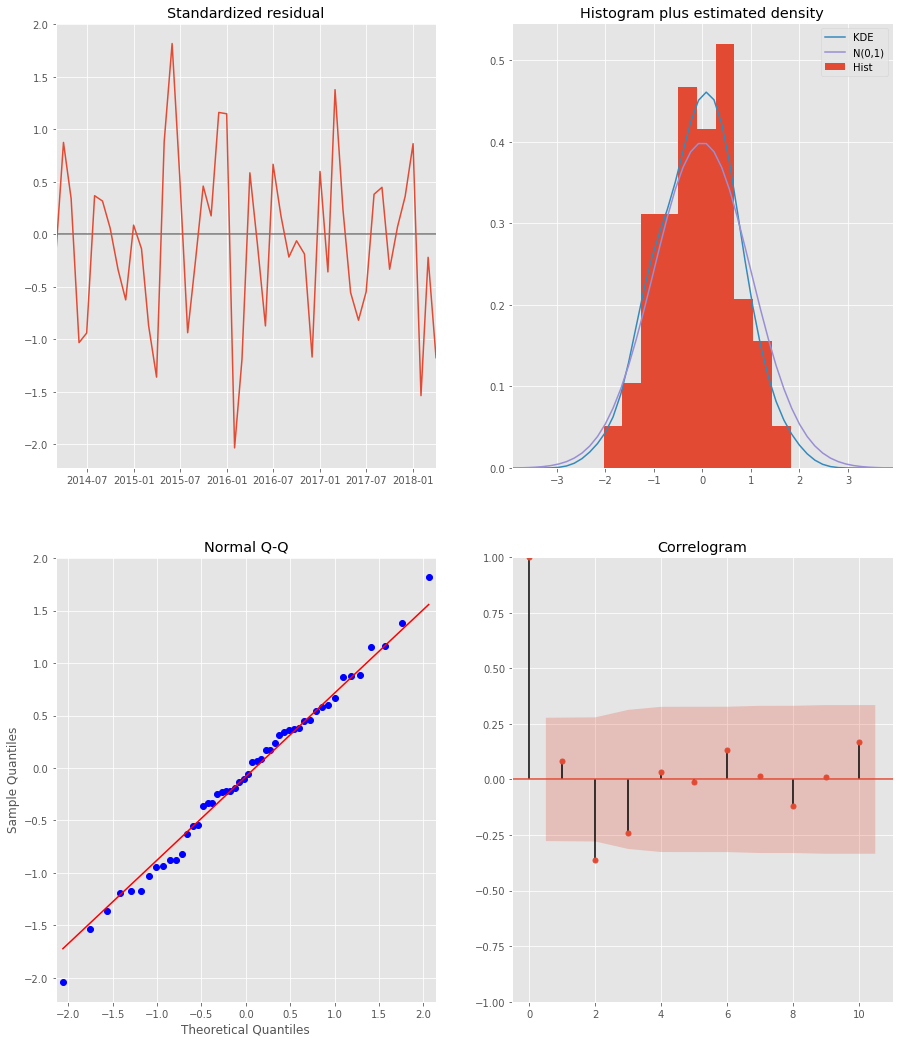

In [74]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [75]:
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

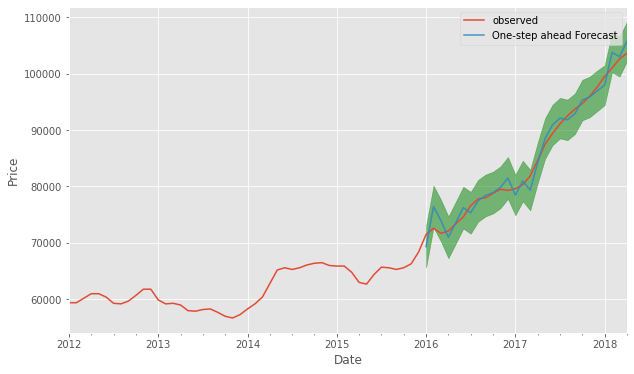

In [84]:

rcParams['figure.figsize'] = 10, 6

# Plot observed values
ax = top_10_df_2012_up['76164'].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

In [79]:
# Get the real and predicted values
forecasted_76164_2012 = pred.predicted_mean
truth_76164_2012 = top_10_df_2012_up['76164']['2016-01-01':]

# Compute the mean square error
mse = ((forecasted_76164_2012 - truth_76164_2012) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2313487.5


In [80]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

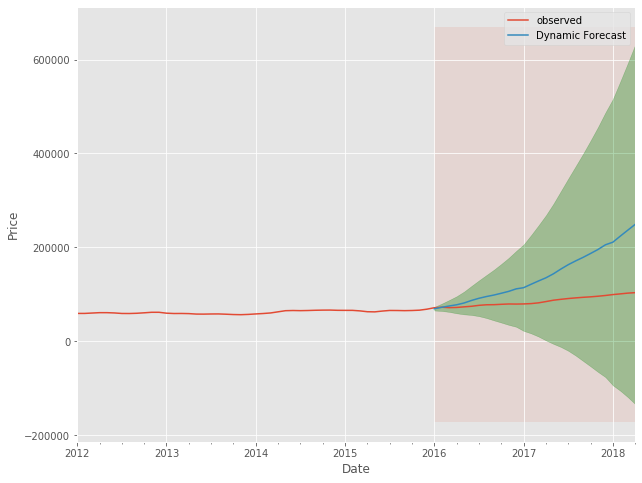

In [83]:

ax = top_10_df_2012_up['76164'].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), forecasted_76164_2012.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

#### 76014

In [146]:
top_10_df.head()

Zipcode     76164  76114  76117  76105  76010  76111  76119   76107  76104  \
1996-04-01  40300  56000  56700  33100  56100  52300  40500  122600  35500   
1996-05-01  40400  56000  56800  33600  56200  52300  40600  124100  35600   
1996-06-01  40400  56000  56800  34100  56300  52300  40700  125700  35700   
1996-07-01  40500  56100  57000  34600  56500  52300  40800  127200  35800   
1996-08-01  40500  56200  57100  35000  56600  52300  41000  128700  35800   

Zipcode     76103  
1996-04-01  55000  
1996-05-01  55100  
1996-06-01  55300  
1996-07-01  55400  
1996-08-01  55600

In [147]:
p = range(0, 3)
d = range(1, 3)
q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top_10_df['76010'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3914.5795407448268
ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3712.7807738446036


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3536.9463434746904
ARIMA (0, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3960.2779827448326


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3659.567586903635


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3392.1998162699497
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3726.0225790970517


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3713.0073132872612


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3538.931244062812
ARIMA (0, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3660.7648214110322


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3625.998776007371


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3381.975721735894
ARIMA (0, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3552.1814628255743


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3552.9104800780633


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3540.438726063977


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3408.0499980132427


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3406.291347143472


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3392.0409542992056


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3692.4821796678552


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3455.9877726781433


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3292.444412479742


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3752.3915240670153


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3427.6775086824828


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3160.4328610307048


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3509.7339053829364


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3457.4490101330557


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3294.3521157548175


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3508.90745310871


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3434.257894422533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3162.42890956452


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3324.4937699673856


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3322.9010409529915


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3296.350489801485


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3258.907010948731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3239.483979555601


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3163.0637541708693


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3566.257454517867


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3344.013073984479


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3182.970273724074


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3638.9867013245957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3323.0676655501047


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3064.795492567684


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3450.25803514377


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3370.0040517028438


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3184.9055707543703


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3441.6188696513573


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3315.4772265930374


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3097.5361816420927


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3231.023035524233


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3229.1524568759714


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3186.8273363585304


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3177.914632713878


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3142.82633544725


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3099.081548924475
ARIMA (0, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3629.8064089542404


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3362.3624407359694


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3159.651556682057
ARIMA (0, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3711.003705981348

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3388.3191928897168


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3150.0122507676806
ARIMA (0, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3405.871907173928


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3361.264789240792


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3157.07862475601


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3422.6113176448903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3353.6371667167946


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3149.2392275053107
ARIMA (0, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3199.779632120386

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3200.2792160953168


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3187.221398951906


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3151.13913419399


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3143.412447257324


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3127.2196689402813
ARIMA (0, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3569.196350312337

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3260.7082191756444


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3103.097339373821


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3655.006427383569


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3329.0304505174217


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3014.493792384986


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3390.395125440581


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3331.847607315655


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3104.2315882153334


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3402.6095383045686


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3313.606778429538


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3008.4657327039145


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3187.9272187396637


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3135.2686160461744


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3144.5083641422534


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3144.9053178475424


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3146.611325046136


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3010.237095859121


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3551.521934314013


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3243.6446209975725


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3082.7882303003917


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3635.8052279241874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3313.8109772611797


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =2994.4501763929775


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3382.5220572632725


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3314.6060538769493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3084.3419909795703


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3395.9494165594338


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3298.3195463568054


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =2989.914664427802


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3181.3840025160625


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3128.722813219518


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3126.489175655226


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3136.615919424935


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3128.270911011734


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =2991.58335338891
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3623.1806389969706


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3370.411902170078


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3169.0901228766606


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3704.4265437960985


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3391.917144734658


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3148.391648593294


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3391.3295041347737


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3371.889644974097


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3167.9152128577052


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3402.58127929161


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3357.092904112327


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3147.2412124533653


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3191.1850875289865


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3192.260501146602


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3192.5848489683794


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3135.3340584282123


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3127.8903442435535


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3125.7433342625027


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3550.8667648080386


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3261.955136171474


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3106.6553638349483


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3637.012569045315


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3310.923596468844


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3018.909053984775


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3366.2271057641033


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3327.7641530265655


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3107.0513978753465


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3375.2092074053016


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3298.774972774234


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3012.1811035832325


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3171.0871389928984


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3123.4537880714643


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3109.0222569449224


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3119.800614293011


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3104.410062839186


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3078.4010832924646


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3532.8503887685874


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3250.8580578804826


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3092.561357001979


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3616.5936674322847


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3295.1548604566306


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3008.4901572806193


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3367.1892104819485


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3308.2652516925646


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3093.621413373233


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3377.173692158095


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3281.078804610511


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3073.6636427822855


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3173.4314702791


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3123.679050709316


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3096.046113320338


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3120.3132474938548


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3108.6880059452214


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3063.207707230027
ARIMA (1, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3609.5259558237885


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3328.986347646149


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3142.4083903980245
ARIMA (1, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3693.7244703114493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3364.754702409302


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3121.0977013471384


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3374.230592257609


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3330.6946471467445


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3140.7909829019154


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3386.4363414549275


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3326.2203819109873


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3122.8693669604245


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3173.9729866257476


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3173.799502801777


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3173.84428467012


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3130.0822862590176


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3120.5025976313427


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3117.3819763598995


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3569.1191659589254


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3261.724963567125


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3102.390542589256


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3654.907077844339


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3353.6813872793073


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3011.9814301246392


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3358.268640157983


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3333.308426572007


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3104.148870663462


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3367.832413670836


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3315.605204221725


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3007.0831433359817


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3161.876077175514


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3161.8481159076887


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3144.867935172461


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3118.7279962404355


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3124.5153098336523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3088.540636746202


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3534.949288979765


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3228.358739145311


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3068.618981645835


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3616.760483768002


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3304.950100758724


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =2983.0332779613327


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3338.6086156082765


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3301.7733621551074


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3069.9851135496265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3357.901784736236


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3292.2645522047533


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3029.4961580738927


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3147.504873092643


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3109.072929607968


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3071.925705842252


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3114.270977375666


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3098.107362785057


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (1, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =2979.572297882442
ARIMA (2, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3565.2796337596305


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3334.0934109500713


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 1, 2, 12)12 : AIC Calculated =3145.8216034939073


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 0, 12)12 : AIC Calculated =3647.163233787146


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 1, 12)12 : AIC Calculated =3353.415441805731


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (0, 2, 2, 12)12 : AIC Calculated =3104.1247216017164


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3342.8355550354736


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3336.827044141668


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 1, 2, 12)12 : AIC Calculated =3145.3841185759816


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 0, 12)12 : AIC Calculated =3338.3520752779023


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 1, 12)12 : AIC Calculated =3302.878432792957


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (1, 2, 2, 12)12 : AIC Calculated =3085.1720388279164


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =3156.1159359753356


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =3156.8456690395033


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =3157.631144211765


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =3100.7033228944774


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =3101.213200731496


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =3088.547175181785
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3551.8678613771804

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3263.6010291219377


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =3107.7403334445826


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =3636.9994748268227


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =3311.534332493619


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =3020.0233946661115


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3332.7060843160525


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3327.6552759364467


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =3108.94482972274


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =3328.5213847378823


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =3295.5234111830523


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =3087.963103015303


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =3147.3532946374144


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =3109.2061686277534


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =3110.9298964081886


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 0, 12)12 : AIC Calculated =3092.9255621932557


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 1) x (2, 2, 1, 12)12 : AIC Calculated =3067.8799350044064


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 1) x (2, 2, 2, 12)12 : AIC Calculated =3015.7497362680456


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 0, 12)12 : AIC Calculated =3537.9067723054313


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 1, 1, 12)12 : AIC Calculated =3243.879217320883


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 1, 2, 12)12 : AIC Calculated =3089.615241706761


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (0, 2, 0, 12)12 : AIC Calculated =3612.8697579815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 1, 12)12 : AIC Calculated =3297.493754164677


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (0, 2, 2, 12)12 : AIC Calculated =3002.4631674300044


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 1, 0, 12)12 : AIC Calculated =3336.459141466311


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 1, 12)12 : AIC Calculated =3307.3995114050877


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 1, 2, 12)12 : AIC Calculated =3093.380687743345


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 1, 2) x (1, 2, 0, 12)12 : AIC Calculated =3330.5461951934394


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 1, 12)12 : AIC Calculated =3283.81400577898


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (1, 2, 2, 12)12 : AIC Calculated =3094.459423282183


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 0, 12)12 : AIC Calculated =3145.137623351272


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 1, 12)12 : AIC Calculated =3154.2715038394817


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 1, 2, 12)12 : AIC Calculated =3122.662236765733


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 0, 12)12 : AIC Calculated =3095.6278303169534


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 1, 12)12 : AIC Calculated =3082.9188043219283


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 1, 2) x (2, 2, 2, 12)12 : AIC Calculated =3078.0758633711007
ARIMA (2, 2, 0) x (0, 1, 0, 12)12 : AIC Calculated =3557.7439722467416


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 1, 12)12 : AIC Calculated =3295.6915059550265


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 1, 2, 12)12 : AIC Calculated =3106.8675010974293
ARIMA (2, 2, 0) x (0, 2, 0, 12)12 : AIC Calculated =3642.7276918840107


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 1, 12)12 : AIC Calculated =3332.0066952243887


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (0, 2, 2, 12)12 : AIC Calculated =3077.6187569673466


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 0, 12)12 : AIC Calculated =3320.1688831204647


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 1, 12)12 : AIC Calculated =3298.4550200889457


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 1, 2, 12)12 : AIC Calculated =3106.267710260815


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 0, 12)12 : AIC Calculated =3324.2766862288927


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 1, 12)12 : AIC Calculated =3285.018812303919


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (1, 2, 2, 12)12 : AIC Calculated =3058.6339409691873


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 0, 12)12 : AIC Calculated =3133.277332515294


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 1, 12)12 : AIC Calculated =3133.503627312264


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 1, 2, 12)12 : AIC Calculated =3132.9118762957596


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 0, 12)12 : AIC Calculated =3090.749641941493


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 1, 12)12 : AIC Calculated =3086.7193421548573


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 0) x (2, 2, 2, 12)12 : AIC Calculated =3077.687653715622


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 0, 12)12 : AIC Calculated =3559.642134409539


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 1, 12)12 : AIC Calculated =3287.7694842478522


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 1, 2, 12)12 : AIC Calculated =3089.3491586768214


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 0, 12)12 : AIC Calculated =3643.682710909754


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 1, 12)12 : AIC Calculated =3315.4589890408893


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (0, 2, 2, 12)12 : AIC Calculated =3012.371625000177


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 0, 12)12 : AIC Calculated =3320.073087511191


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 1, 12)12 : AIC Calculated =3288.831955948096


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 1, 2, 12)12 : AIC Calculated =3088.4888615692334


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 0, 12)12 : AIC Calculated =3324.2604287904296


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 1, 12)12 : AIC Calculated =3302.6030951817243


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (1, 2, 2, 12)12 : AIC Calculated =3075.99607063896


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 0, 12)12 : AIC Calculated =3135.068385095252


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 1, 12)12 : AIC Calculated =3134.728220662565


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 1, 2, 12)12 : AIC Calculated =3089.0291025557262


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 0, 12)12 : AIC Calculated =3111.227323490022


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 1) x (2, 2, 1, 12)12 : AIC Calculated =3085.398916373661


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 1) x (2, 2, 2, 12)12 : AIC Calculated =3098.4764480428366


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =3536.3708987415557


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =3230.245144773903


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =3068.313205477267


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =3618.854652134597


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =3299.7044900597293


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =2985.057826776373


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =3315.983635074852


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =3230.3523960465645


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =3070.1588307385086


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =3320.2963835986575


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =3270.8597113947726


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =2979.4238289068385


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =3129.0473736899826


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =3129.0376727315343


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =3071.587646497567


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA (2, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =3091.3196779908203


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =3080.3733344475313


C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (2, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =2981.5062392989944


In [148]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 2)
pdqs    (1, 2, 2, 12)
aic           2979.42
Name: 317, dtype: object

In [150]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(top_10_df_2012_up['76010'], 
                                        order=(2, 2, 2), 
                                        seasonal_order=(1, 2, 2, 12), 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Graham\AppData\Roaming\Python\Python36\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2615      1.927      0.136      0.892      -3.515       4.038
ar.L2          0.0886      1.451      0.061      0.951      -2.755       2.933
ma.L1         -0.2828      1.916     -0.148      0.883      -4.038       3.472
ma.L2         -0.1330      1.460     -0.091      0.927      -2.995       2.729
ar.S.L12       0.5750      0.176      3.270      0.001       0.230       0.920
ma.S.L12      -1.0244      0.225     -4.545      0.000      -1.466      -0.583
ma.S.L24       0.0091      0.111      0.082      0.935      -0.209       0.227
sigma2      6.605e+05   3.21e-07   2.06e+12      0.000     6.6e+05     6.6e+05


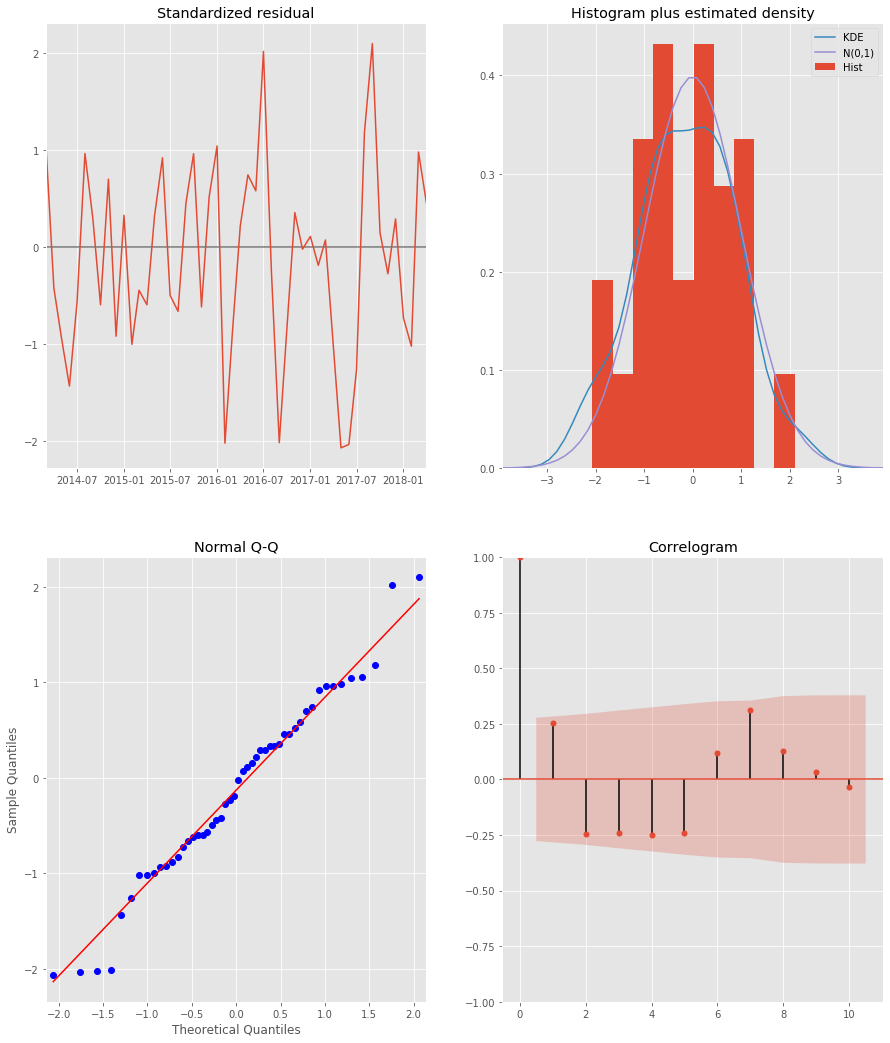

In [151]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
lag_acf = acf(top_10_df_diff['76164'], nlags=20)
lag_pacf = pacf(top_10_df_diff['76164'], nlags=20, method='ols')

In [ ]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_all_diff['76164'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_all_diff['76164'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_all_diff['76164'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_all_diff['76164'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 9)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(top_10_df['76164'],
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [ ]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df_all_diff['76164'], 
                                        order=(1, 0, 1), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

In [ ]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = output.get_prediction(start=pd.to_datetime('1996-05-01'), dynamic=False)
pred_conf = pred.conf_int()

In [ ]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = df_all_diff['76164'].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()

plt.show()

# Step 6: Interpreting Results